## Globals

In [1]:
import numpy as np
import pandas as pd
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from IPython.core.debugger import set_trace
import warnings
import random
import copy
import time

np.random.seed(10)

Set this variable to redo the grid search

In [102]:
do_grid_search = True

## Softmax Regression

Error functions that are used in Gradient Descent

In [103]:
def err_identity(yhat, y):   #use identity as error function, which is the default
    N,C = y.shape
    pred = np.reshape(np.argmax(yhat,1), (N,1))
    true = np.reshape(np.argmax(y,1), (N,1))    #making sure they are in the same shape
    dif = pred-true
    dif = dif[dif != 0]   #see the lines that do not agree each other
    return dif.size/N     #return error rate given number of error within N samples

def err_difp1(yhat, y):   #use p1 norm as error function
    return np.sum(np.abs(yhat - y))

def err_difp2(yhat, y):   #use p2 norm as error function
    return np.linalg.norm(yhat - y, 'fro')

Cost function

In [104]:
def costfn(X, W, Y):
    N,_ = Y.shape   #getting number of samples
    Z = X @ W       #getting z
    return (np.sum(logsumexp(Z, axis=1)) - np.matrix.trace(Y @ Z.T))/N  #returning average cost

Functions used by SoftmaxRegression and GD

In [105]:
def softmax(x):  #do softmax to every row of x
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

def predict(x,w):
    #x: N*D
    #w: D*C
    #z: N*C
    z = x @ w
    return softmax(z)

In [106]:
class SoftmaxRegression:
    def __init__(self, num_classes, add_bias=False, err_fn=err_identity):
        self.add_bias = add_bias
        self.err_fn = err_fn
        self.num_classes = num_classes
            
    def fit(self, x_t, y_t, x_v, y_v, optimizer):
        if self.add_bias:  #add a column of 1 to x
            N = x_t.shape[0]
            x_t = np.column_stack([x_t, np.ones(N)])
            M = x_v.shape[0]
            x_v = np.column_stack([x_v, np.ones(M)])
        N, D = x_t.shape
        w0 = np.zeros((D, self.num_classes))  #initialization
        self.w = optimizer.run(SoftmaxRegression.gradient, self.err_fn,
                               x_t, y_t, w0, x_v, y_v) #gradient descent
        return self
    
    def predict(self, x):
        if x.ndim == 1: # quick fix if x is 1d array
            x = x.reshape((1,-1))
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        return predict(x, self.w)    #it is just a special case of predict, so we call the global method

    @staticmethod
    def gradient(x, y, w):
        yh =  softmax(x @ w)
        N, D = x.shape
        grad = (x.T @ (yh - y)) / N  #applying gradient descent formula, and get average
        return grad

## Gradient Descent

function related to learning rate

In [107]:
def learning_rate_const(x0,T):   #this is what we will mostly use
    return x0
def learning_rate_m05(x0,T):    #decreasing learning rate with power -0.5, with respect to an initial learning rate and the number of iteration
    return x0/T**0.5
def learning_rate_m07(x0,T):   #similarly for power -0.7
    return x0/T**0.7
def learning_rate_m10(x0,T):   #similarly for power -1.0
    return x0/T

Gradient Descent class(for mini-batch)

In [110]:
class GradientDescent:
    def __init__(self, 
                 inilearning_rate = 0.1,   #it is the learning rate for the first iteration; it can be the same for const learning rate, or decreasing for others.
                 learning_rate_fn = learning_rate_m05,
                 momentumbeta = 0.95,     #for amount of momentum
                 batch_size = 16,         #size of mini-batch
                 max_iters=1e4,           #maximum of iteration
                 epsilon=1e-8,            #if norm of gradient is less than epsilon, GD stops
                 T = 100,                 #if there is no improving on validation error for T iterations, GD stops
                 record_history=False
                 ):
        self.inilearning_rate = inilearning_rate
        self.learning_rate_fn = learning_rate_fn
        self.momentumbeta = momentumbeta
        self.batch_size = batch_size
        self.max_iters = max_iters
        self.err_history = []             #we need to track validation error history to terminate GD
        self.epsilon = epsilon
        self.T = T
        self.record_history = record_history
        if record_history:
            self.w_history = []           #to track change of w
        self.smallest = np.inf            #to track and update the current lowest validation error
        self.w = None                     #to track and update w for a lower valiation error each time
        self.curpos = 0                   #to split training data into batches; curpos is the numher of batches GD is currently on
        self.t_err_history = []           #training_error history
        self.cost_history = []            #cost (cost function given x, w, and y) of current value(w)
        
    
    def run(self, gradient_fn,            #usually it is the default gradient
            error_type,                   #error_type is refering to err_identity, err_difp1, err_difp2, normally err_identity
            x_train, y_train, w,          #w is the initial w
            x_validation, y_validation):
        grad = np.ones_like(w)*np.inf     #gradient    D * C  (we cannot make it 0 because while loop requires norm of grad is larger than epsilon)
        changew = np.zeros_like(grad)     #(actual) change of w
        self.w = w                        #initialize w
        if self.record_history:
            self.w_history.append(w)
        #get the errors and cost for the first w
        self.err_history.append(error_type(predict(x_validation, w), y_validation))
        self.t_err_history.append(error_type(predict(x_train, w), y_train))
        self.cost_history.append(costfn(x_validation, w, y_validation))
        
        N,D = x_train.shape
        indexes = np.arange(N)
        idex_folds = np.array_split(indexes, 1.0*N/self.batch_size)    #begin slicing      
        
        t = 1
        while (np.linalg.norm(grad) > self.epsilon) and (t < self.max_iters): #stopping condition
            xt = x_train[idex_folds[self.curpos], :]
            yt = y_train[idex_folds[self.curpos], :]
            
            grad = gradient_fn(xt, yt, w)     #calculate gradient probably by gradient_fn for the mini-batch
            changew = changew * self.momentumbeta + (1-self.momentumbeta) * grad    #change of w with momentum
            Lrate = self.learning_rate_fn(self.inilearning_rate, t)    #learning_rate. See learning_rate functions.


            w = w - Lrate * changew           #gradient descent
            
            
            #append validation accuracy, training accuracy and cost
            if self.record_history:
                self.w_history.append(w)
            curerror = float(error_type(predict(x_validation, w), y_validation))  #error for current w
            self.t_err_history.append(error_type(predict(x_train, w), y_train))
            self.cost_history.append(costfn(x_validation, w, y_validation))
            if(curerror < self.smallest):
                self.smallest = curerror
                self.w = w                     #make sure w is the one with smallest error
            self.err_history.append(curerror)
            
            if(len(self.err_history) > self.T): #throw useless err_history, because we are only interested in last T's
                self.err_history.pop(0)
                self.cost_history.pop(0)
            if(min(self.err_history) > self.smallest): #possible termination (when there is no improvement in T steps)
                return self.w
            
            
            t += 1                              #update t
            self.curpos += 1                    #update curpos
            if(self.curpos==len(idex_folds)):   #reset curpos if it is at the last mini-batch
                self.curpos=0
        return self.w

Gradient Descent with ADAM and regularization

In [111]:
class GradientDescentEXTRA: #it is ADAM implementation adding a regularization
    def __init__(self, 
                 inilearning_rate = 0.1, 
                 learning_rate_fn = learning_rate_m05,
                 momentumbeta = 0.94,
                 batch_size = 16, 
                 max_iters=1e4, 
                 epsilon=1e-8,
                 T = 100,                       #for termination comparison
                 Lambda = 0.2,                  #for regularization
                 RMSbeta = 0.999,               #RMSbeta value(for second moment), typically 0.999
                 record_history=False
                 ):
        self.inilearning_rate = inilearning_rate
        self.learning_rate_fn = learning_rate_fn
        self.momentumbeta = momentumbeta
        self.batch_size = batch_size
        self.max_iters = max_iters
        self.err_history = []
        self.epsilon = epsilon
        self.T = T
        self.Lambda = Lambda
        self.RMSbeta = RMSbeta
        self.record_history = record_history
        if record_history:
            self.w_history = []
        self.smallest = np.inf
        self.w = None
        self.curpos = 0
        self.t_err_history = []
        self.cost_history = []
    
    
    
    def run(self, gradient_fn,  
            error_type, 
            x_train, y_train, w, 
            x_validation, y_validation,
            biased = False               #for regularization (we do not want to penalize bias)
            ):
        grad = np.ones_like(w)*np.inf    
        m = np.zeros_like(grad)
        v = np.zeros_like(grad)          #for second moment(RMS part)
        self.w = w                       #initialize w
        if self.record_history:
            self.w_history.append(w)
        self.err_history.append(error_type(predict(x_validation, w), y_validation))
        self.t_err_history.append(error_type(predict(x_train, w), y_train))
        self.cost_history.append(costfn(x_validation, w, y_validation))
        
        N,D = x_train.shape
        indexes = np.arange(N)
        idex_folds = np.array_split(indexes, 1.0*N/self.batch_size)        
        
        t = 1
        while (np.linalg.norm(grad) > self.epsilon) and (t < self.max_iters): 
            xt = x_train[idex_folds[self.curpos], :]
            yt = y_train[idex_folds[self.curpos], :]
            
            grad = gradient_fn(xt, yt, w)
            if biased:
                grad[:-1,:] += self.Lambda*w[:-1,:]                        #add regularization: not penalizing bias
            else:
                grad += self.Lambda*w
            m = m * self.momentumbeta + (1-self.momentumbeta) * grad       #change of w with momentum
            m_corrected  = 1.0 * m / (1 - np.power(self.momentumbeta, t))  #to make the several m's at a normal value(instaed of being scaled down)
            v = self.RMSbeta * v + (1 - self.RMSbeta) * np.square(grad)    #second momentum
            v_corrected = v / (1 - np.power(self.RMSbeta, t))              #similarly to correct v
            Lrate = self.learning_rate_fn(self.inilearning_rate, t)        #learning_rate of this gradient

            w = w - Lrate * m_corrected / (np.sqrt(v_corrected) + 1e-8)    #gradient descent for ADAM
            
            if self.record_history:
                self.w_history.append(w)
            curerror = float(error_type(predict(x_validation, w), y_validation))  #error for current w
            self.t_err_history.append(error_type(predict(x_train, w), y_train))
            self.cost_history.append(costfn(x_validation, w, y_validation))
            if(curerror < self.smallest):
                self.smallest = curerror
                self.w = w                            #make sure w is the one with smallest error
            self.err_history.append(curerror)
            
            if(len(self.err_history) > self.T):       #throw useless err_history
                self.err_history.pop(0)
                self.cost_history.pop(0)
            if(min(self.err_history) > self.smallest): #possible terminate (when there is no improvement in last T steps)
                return self.w
            
            
            t += 1                                     #update t
            self.curpos += 1                           #update curpos
            if(self.curpos==len(idex_folds)):          #reset curpos if it is at the last mini-batch
                self.curpos=0
        return self.w

## Analysis


### Pre-processing datasets

Loading the datasets

In [112]:
digits_x, digits_y = load_digits(n_class=10, return_X_y=True)
digits_c = 10

# Letter Dataset from OpenML
#https://www.openml.org/d/6
letters_x, letters_y = fetch_openml(data_id=6, return_X_y=True)
letters_c = 26

print(digits_x.shape)   #check the shape
print(letters_x.shape)  #check the shape

(1797, 64)
(20000, 16)
(28056, 6)


Applying one-hot encoding (It is the only preprocessing we need, because we do not have missing values)

In [114]:
def one_hot_encode(y):
    ret = np.zeros((len(y), digits_c))        #create the categoric matrix
    ret[np.arange(len(y)), y] = 1             #select the correct label to 1
    return ret

# Applying one hot encoding to the y labels for letter dataset
digits_y = one_hot_encode(digits_y)


# Applying one hot encoding to the y labels for letter dataset
class_labels = np.zeros((len(letters_y), 26))
for index,character in enumerate(letters_y):
    class_label = ord(character) - ord('A')
    class_labels[index][class_label]=1
letters_y = class_labels

### Implementation of K-Fold cross validation

In [2]:
class KFold:
    def __init__(self, k=5):
        self.k = k
    
    def split(self, x, y):
        indexes = list(range(len(x)))
        np.random.shuffle(indexes)
        idx_folds = np.array_split(indexes, self.k)
        for i in range(self.k):
            test_idx = idx_folds[i]
            train_idx = np.concatenate(*[idx_folds[:i] + idx_folds[i+1:]]).flatten()
            yield (x[train_idx], y[train_idx]) , (x[test_idx], y[test_idx])


Function to perform 5-fold cross validation on passed model and dataset

In [116]:
def score(model, x, y):            #score of the model (similarly to err_identity function)
    yhat = model.predict(x)
    N,C = y.shape
    pred = np.reshape(np.argmax(yhat,1), (N,1))
    true = np.reshape(np.argmax(y,1), (N,1))   
    dif = pred-true
    dif = dif[dif == 0]
    return dif.size/N


#Returns the training accuracy and validation accuracy of the model by performing k-fold cross validation
def kfold_cross_validate( model, optimizer, x, y, kfold_num=5 ):
    kfold = KFold(k=kfold_num)
    validation_accuracy = 0
    training_accuracy = 0
    avg_cost = 0
    opt = copy.copy(optimizer)                                     #keep a copy of "empty" optimizer
    
    for (x_train, y_train), (x_test, y_test) in kfold.split(x,y):
        optz = copy.copy(opt)                                      #use a initialized optimizer each time
        model.fit(x_train, y_train, x_test, y_test, optz)          #fit model
        training_accuracy += score( model, x_train, y_train)       #return training accuracy
        validation_accuracy += score( model, x_test, y_test)       #return validation accuracy
        avg_cost += costfn(x_test,optz.w,y_test)                   #return cost
    
    return training_accuracy/kfold_num , validation_accuracy/kfold_num, avg_cost/kfold_num    #return average training and validation accuracy, and cost

Plotting

In [117]:
def visualize(x_label, y_label):        #set up a graph pattern to plot easily later
    _, (axes_digits, axes_letters) = plt.subplots(1,2)

    #set position of two graphs(one for digit, another for letters)
    chartBox = axes_digits.get_position()
    axes_digits.set_position([chartBox.x0, chartBox.y0,
                            chartBox.width*2.5, chartBox.height*1.5]) 
    chartBox = axes_letters.get_position() 
    axes_letters.set_position([0.6+chartBox.x0, chartBox.y0,
                             chartBox.width*2.5, chartBox.height*1.5])

    axes_digits.set_title(f'{y_label} vs {x_label} (Digits)')        #set title
    axes_digits.set_xlabel(x_label)                                  #set name of x axis
    axes_digits.set_ylabel(y_label)                                  #set name of y axis
    axes_digits.title.set_size(23)                                   #set font of title
    axes_digits.xaxis.label.set_size(18)                             #set font of name of x axis
    axes_digits.yaxis.label.set_size(16)                             #set font of name of y axis
    axes_digits.tick_params(axis = 'both', which = 'major', labelsize = 16) #set fond of values on x and y axis

    #and the same setting for letters graph
    axes_letters.set_title(f'{y_label} vs {x_label} (Letters)')
    axes_letters.set_xlabel(x_label)
    axes_letters.set_ylabel(y_label)
    axes_letters.title.set_size(23)
    axes_letters.xaxis.label.set_size(18)
    axes_letters.yaxis.label.set_size(16)
    axes_letters.tick_params(axis = 'both', which = 'major', labelsize = 16)

    return axes_digits, axes_letters

### Implementation of Grid Search for Softmax Regressor

In [118]:
# Returns all hyperparameter combinations possible from the passed parameter list
# NOTE: ONLY WORKS FOR GRADIENT DESCENT ( Class: GradientDescent ) OPTIMIZER PARAMS

def get_all_param_combinations( params ):
    params_list = np.array(list(params.values()))
    param_combinations = np.array(np.meshgrid(
                              params_list[0],
                              params_list[1],
                              params_list[2],
                              params_list[3],
                              params_list[4],
                              params_list[5],
                              params_list[6],
                              params_list[7],
                              )).T.reshape(-1,8)
    return param_combinations



# Returns all hyperparameter combinations possible from the passed parameter list
# NOTE: ONLY WORKS FOR ADAMS GRADIENT DESCENT ( Class: GradientDescentEXTRA ) OPTIMIZER PARAMS 
def get_all_param_combinations_EXTRA( params ):
    params_list = np.array(list(params.values()))
    param_combinations = np.array(np.meshgrid(
                              params_list[0],
                              params_list[1],
                              params_list[2],
                              params_list[3],
                              params_list[4],
                              params_list[5],
                              params_list[6],
                              params_list[7],
                              params_list[8],
                              params_list[9],
                              )).T.reshape(-1,10)
    return param_combinations




# Grid-Search over all possible hyperparameters defined by optimiser_params
# num_classes is the number of classes for the softmax regressor
# x is the input dataset
# y is the label dataset
# Set display to True to see the stats of each hyperparameter configuration

# Returns:
# best_model: Best Softmax Regressor found by the grid search
# best_params: Hyperparameters of the best softmax regressor
# training_accuracies: Training Accuracy of each hyperparameter combination
# validation_accuracies: Validation Accuracy of each hyperparameter combination
# running_times,costs: Running time of each hyperparameter combination

# NOTE: ONLY WORKS FOR GRADIENT DESCENT ( Class: GradientDescent ) OPTIMIZER PARAMS


def grid_search_softmax_regressor(optimiser_params, num_classes, x, y, display = False ):
  #not necessarily for all parameter combinations. Maybe only varying one hyperparameter
  param_combinations = get_all_param_combinations(optimiser_params)

  best_model = None
  best_params = None

  max_validation_accuracy = 0;
  # Arrays to be returned for plotting purposes
  training_accuracies = []
  validation_accuracies = []
  running_times = []
  costs = []

  for index,param_combination in enumerate(param_combinations):
    softmaxregressor = SoftmaxRegression(num_classes)
    optimizer = GradientDescent(inilearning_rate= param_combination[0], 
                                learning_rate_fn= param_combination[1],
                                momentumbeta= param_combination[2],
                                batch_size= param_combination[3], 
                                max_iters= param_combination[4], 
                                epsilon= param_combination[5],
                                T= param_combination[6],  
                                record_history= param_combination[7])
    start = time.time()
    training_accuracy, validation_accuracy, cost = kfold_cross_validate( softmaxregressor, optimizer, x, y, kfold_num=5)
    runtime = time.time()-start

    if display:
      print("--- HYPERPARAMETERS COMBINATION {} ---\n".format(index))
      print("'inilearning_rate': {}\n'learning_rate_fn': {}\n'momentumbeta': {}\n'batch_size': {}\n'max_iters': {}\n'epsilon': {}\n'T': {}\n'record_history': {}\n"
      .format(param_combination[0],param_combination[1],param_combination[2],param_combination[3],param_combination[4],param_combination[5],param_combination[6],param_combination[7]))
      print(" Training Accuracy: {}%".format(training_accuracy*100));
      print(" Validation Accuracy: {}%".format(validation_accuracy*100));
      print(" Run time: {} seconds".format(runtime));
      print(" Cost: {}\n".format(cost));

    training_accuracies.append(training_accuracy)
    validation_accuracies.append(validation_accuracy)
    running_times.append(runtime)
    costs.append(cost)

    if validation_accuracy>max_validation_accuracy:
      best_params = param_combination
      best_model = softmaxregressor
      max_validation_accuracy = validation_accuracy
  
  return best_model,best_params, training_accuracies, validation_accuracies, running_times,costs







# Grid-Search over all possible hyperparameters defined by optimiser_params
# num_classes is the number of classes for the softmax regressor
# x is the input dataset
# y is the label dataset
# Set display to True to see the stats of each hyperparameter configuration

# Returns:
# best_model: Best Softmax Regressor found by the grid search
# best_params: Hyperparameters of the best softmax regressor
# training_accuracies: Training Accuracy of each hyperparameter combination
# validation_accuracies: Validation Accuracy of each hyperparameter combination
# running_times,costs: Running time of each hyperparameter combination

# NOTE: ONLY WORKS FOR ADAM GRADIENT DESCENT ( Class: GradientDescentEXTRA ) OPTIMIZER PARAMS


def grid_search_softmax_regressor_EXTRA(optimiser_params, num_classes, x, y, display = False ):
  #not necessarily for all parameter combinations. Maybe only varying one hyperparameter
  param_combinations = get_all_param_combinations_EXTRA(optimiser_params)

  best_model = None
  best_params = None

  max_validation_accuracy = 0;
  # Arrays to be returned for plotting purposes
  training_accuracies = []
  validation_accuracies = []
  running_times = []
  costs = []
  
  for index,param_combination in enumerate(param_combinations):
    softmaxregressor = SoftmaxRegression(num_classes)
    optimizer = GradientDescentEXTRA(inilearning_rate= param_combination[0], 
                                learning_rate_fn= param_combination[1],
                                momentumbeta= param_combination[2],
                                batch_size= param_combination[3], 
                                max_iters= param_combination[4], 
                                epsilon= param_combination[5],
                                T= param_combination[6],  
                                record_history= param_combination[7],
                                Lambda= param_combination[8], 
                                RMSbeta=param_combination[9]
                                )
    start = time.time()
    training_accuracy, validation_accuracy, cost = kfold_cross_validate( softmaxregressor, optimizer, x, y, kfold_num=5)
    runtime = time.time()-start
    if display:
      print("--- HYPERPARAMETERS COMBINATION {} ---\n".format(index))
      print("'inilearning_rate': {}\n'learning_rate_fn': {}\n'momentumbeta': {}\n'batch_size': {}\n'max_iters': {}\n'epsilon': {}\n'T': {}\n'record_history': {}\n'Lambda': {}\n'RMSbeta': {}\n"
      .format(param_combination[0],param_combination[1],param_combination[2],param_combination[3],param_combination[4],param_combination[5],param_combination[6],param_combination[7],param_combination[8],param_combination[9]))
      print(" Training Accuracy: {}%".format(training_accuracy*100));
      print(" Validation Accuracy: {}%".format(validation_accuracy*100));
      print(" Run time: {} seconds".format(runtime));
      print(" Cost: {}\n".format(cost));

    training_accuracies.append(training_accuracy)
    validation_accuracies.append(validation_accuracy)
    running_times.append(runtime)
    costs.append(cost)

    if validation_accuracy>max_validation_accuracy:
      best_params = param_combination
      best_model = softmaxregressor
      max_validation_accuracy = validation_accuracy
  
  return best_model,best_params, training_accuracies, validation_accuracies, running_times,costs

### Finding best Gradient Descent Hyperparameters via Grid Search


Note: The following code blocsk take quite some time to run

In [119]:
# All optimiser params possibilities to test the grid_search
all_optimiser_params={
    'inilearning_rate': [0.005, 0.01, 0.025, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5], 
    'learning_rate_fn': [learning_rate_const, learning_rate_m05],
    'momentumbeta': [0.85, 0.9, 0.92, 0.95, 0.99],
    'batch_size': [1, 2, 4, 8, 16, 32, 64, 128], 
    'max_iters': [1e4], 
    'epsilon': [1e-8],
    'T': [100],  #for termination comparison
    'record_history': [False]
}

Grid-search over digits dataset

In [120]:
best_model_digits,best_params_digits, _, _, _,_ = grid_search_softmax_regressor(all_optimiser_params,digits_c,digits_x,digits_y, display = True)

Grid-search over letters dataset

In [121]:
best_model_letters,best_params_letters, _, _, _,_ = grid_search_softmax_regressor(all_optimiser_params,letters_c,letters_x,letters_y, display = True)

Show result (The best hyperparameter for each datasets)

In [122]:
print("Best Hyperparameters returned by Grid Search for digits dataset are: ")
print("'inilearning_rate': {}\n'learning_rate_fn': {}\n'momentumbeta': {}\n'batch_size': {}\n'max_iters': {}\n'epsilon': {}\n'T': {}\n'record_history': {}\n"
    .format(best_params_digits[0],best_params_digits[1],best_params_digits[2],best_params_digits[3],best_params_digits[4],best_params_digits[5],best_params_digits[6],best_params_digits[7]))

print("Best Hyperparameters returned by Grid Search for letters dataset are: ")
print("'inilearning_rate': {}\n'learning_rate_fn': {}\n'momentumbeta': {}\n'batch_size': {}\n'max_iters': {}\n'epsilon': {}\n'T': {}\n'record_history': {}\n"
    .format(best_params_letters[0],best_params_letters[1],best_params_letters[2],best_params_letters[3],best_params_letters[4],best_params_letters[5],best_params_letters[6],best_params_letters[7]))
    
    

'\nprint("Best Hyperparameters returned by Grid Search for digits dataset are: ")\nprint("\'inilearning_rate\': {}\n\'learning_rate_fn\': {}\n\'momentumbeta\': {}\n\'batch_size\': {}\n\'max_iters\': {}\n\'epsilon\': {}\n\'T\': {}\n\'record_history\': {}\n"\n    .format(best_params_digits[0],best_params_digits[1],best_params_digits[2],best_params_digits[3],best_params_digits[4],best_params_digits[5],best_params_digits[6],best_params_digits[7]))\n\nprint("Best Hyperparameters returned by Grid Search for letters dataset are: ")\nprint("\'inilearning_rate\': {}\n\'learning_rate_fn\': {}\n\'momentumbeta\': {}\n\'batch_size\': {}\n\'max_iters\': {}\n\'epsilon\': {}\n\'T\': {}\n\'record_history\': {}\n"\n    .format(best_params_letters[0],best_params_letters[1],best_params_letters[2],best_params_letters[3],best_params_letters[4],best_params_letters[5],best_params_letters[6],best_params_letters[7]))\n    \n    \n'

The result is:  
Best Hyperparameters returned by Grid Search for digits dataset are:  
'inilearning_rate': 0.05  
'learning_rate_fn': learning_rate_const  
'momentumbeta': 0.85  
'batch_size': 64  
'max_iters': 10000.0  
'epsilon': 1e-8  
'T': 100  
'record_history': False  

Best Hyperparameters returned by Grid Search for letters dataset are:  
'inilearning_rate': 0.07  
'learning_rate_fn': learning_rate_const  
'momentumbeta': 0.85  
'batch_size': 128  
'max_iters': 10000.0  
'epsilon': 1e-8  
'T': 100  
'record_history': False  

### Gradient Descent Hyperparameter Tuning

The best parameters for each datasets returned by the grid search is saved in this dictionary for future reference.

In [123]:

best_optimiser_params_digits={
    'inilearning_rate': best_params_digits[0], 
    'learning_rate_fn': best_params_digits[1],
    'momentumbeta': best_params_digits[2],
    'batch_size': best_params_digits[3], 
    'max_iters': best_params_digits[4], 
    'epsilon': best_params_digits[5],
    'T': best_params_digits[6], 
    'record_history': best_params_digits[7]
}

best_optimiser_params_letters={
    'inilearning_rate': best_params_letters[0], 
    'learning_rate_fn': best_params_letters[1],
    'momentumbeta': best_params_letters[2],
    'batch_size': best_params_letters[3], 
    'max_iters': best_params_letters[4], 
    'epsilon': best_params_letters[5],
    'T': best_params_letters[6], 
    'record_history': best_params_letters[7]
}

'''
### Just to not run the time-costly gridsearch above
best_optimiser_params_digits={
    'inilearning_rate': 0.05, 
    'learning_rate_fn': learning_rate_const,
    'momentumbeta': 0.85,
    'batch_size': 64, 
    'max_iters': 10000, 
    'epsilon': 1e-08,
    'T': 100, 
    'record_history': False
}

best_optimiser_params_letters={
    'inilearning_rate': 0.07, 
    'learning_rate_fn': learning_rate_const,
    'momentumbeta': 0.85,
    'batch_size': 128, 
    'max_iters': 10000, 
    'epsilon': 1e-08,
    'T': 100, 
    'record_history': False
}
'''

#### Batch Size Tuning



In [124]:
# Varying Batch Size optimiser params
batchsize_optimiser_params_digits={
    'inilearning_rate': best_optimiser_params_digits['inilearning_rate'], 
    'learning_rate_fn': best_optimiser_params_digits['learning_rate_fn'],
    'momentumbeta': best_optimiser_params_digits['momentumbeta'],
    'batch_size': [1,2,3,4,5,6,8,10,16,32,64,128,256],    #we choose these values because we believe there is little change for larger batch sizes, so we increase their gap
    'max_iters': best_optimiser_params_digits['max_iters'], 
    'epsilon': best_optimiser_params_digits['epsilon'],
    'T': best_optimiser_params_digits['T'],
    'record_history': best_optimiser_params_digits['record_history']
}

batchsize_optimiser_params_letters={
    'inilearning_rate': best_optimiser_params_letters['inilearning_rate'], 
    'learning_rate_fn': best_optimiser_params_letters['learning_rate_fn'],
    'momentumbeta': best_optimiser_params_letters['momentumbeta'],
    'batch_size': [1,2,3,4,5,6,8,10,16,32,64,128,256], 
    'max_iters': best_optimiser_params_letters['max_iters'], 
    'epsilon': best_optimiser_params_letters['epsilon'],
    'T': best_optimiser_params_letters['T'],
    'record_history': best_optimiser_params_letters['record_history']
}

##### Training

In [125]:
_,_, training_accuracies_digits, validation_accuracies_digits, running_times_digits, costs_digits = grid_search_softmax_regressor(batchsize_optimiser_params_digits,digits_c,digits_x,digits_y, display = True)

<ipython-input-118-d3bb35c64e88>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'inilearning_rate': 0.05
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 1
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 31.497024302097454%
 Validation Accuracy: 31.774682760755184%
 Run time: 0.15658068656921387 seconds
 Cost: 33.794438574568964

--- HYPERPARAMETERS COMBINATION 1 ---

'inilearning_rate': 0.05
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 2
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 43.466414634878134%
 Validation Accuracy: 42.88594862271742%
 Run time: 0.20345592498779297 seconds
 Cost: 11.965506789128991

--- HYPERPARAMETERS COMBINATION 2 ---

'inilearning_rate': 0.05
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 3
'max_iters': 10000
'epsilon': 1e-08
'T': 10

In [126]:
_,_, training_accuracies_letters, validation_accuracies_letters, running_times_letters, costs_letters = grid_search_softmax_regressor(batchsize_optimiser_params_letters,letters_c,letters_x,letters_y, display = True)

<ipython-input-118-d3bb35c64e88>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'inilearning_rate': 0.07
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 1
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 20.768749999999997%
 Validation Accuracy: 20.9%
 Run time: 70.41878199577332 seconds
 Cost: 19.214541864291604

--- HYPERPARAMETERS COMBINATION 1 ---

'inilearning_rate': 0.07
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 2
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 32.225%
 Validation Accuracy: 32.49000000000001%
 Run time: 105.95162391662598 seconds
 Cost: 10.055807487257642

--- HYPERPARAMETERS COMBINATION 2 ---

'inilearning_rate': 0.07
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 3
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 T

##### Plotting Accuracies

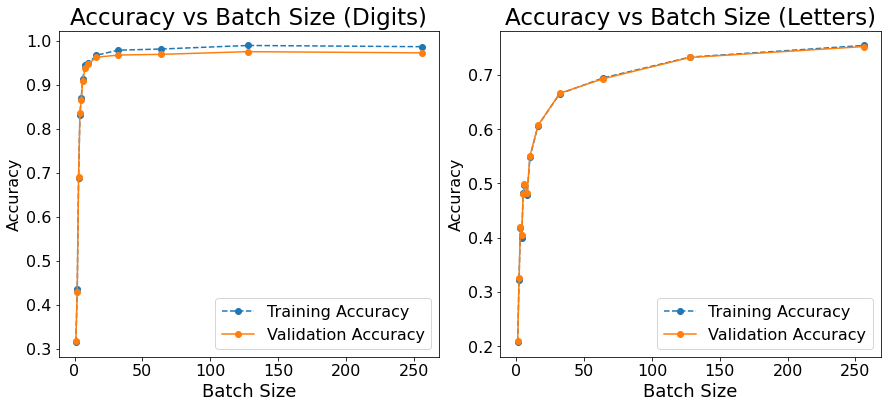

In [127]:
#set up for drawing
axes_digits, axes_letters = visualize('Batch Size', 'Accuracy')

#plot digits graph
axes_digits.plot(batchsize_optimiser_params_digits['batch_size'],training_accuracies_digits, label= "Training Accuracy ", linestyle="--", marker="o")
axes_digits.plot(batchsize_optimiser_params_digits['batch_size'],validation_accuracies_digits, label = "Validation Accuracy", marker="o")

#plot letters graph
axes_letters.plot(batchsize_optimiser_params_letters['batch_size'],training_accuracies_letters, label= "Training Accuracy ", linestyle="--", marker="o")
axes_letters.plot(batchsize_optimiser_params_letters['batch_size'],validation_accuracies_letters, label = "Validation Accuracy", marker="o")

#draw legend
axes_digits.legend(fontsize=16)
axes_letters.legend(fontsize=16)

##### Plotting Running time

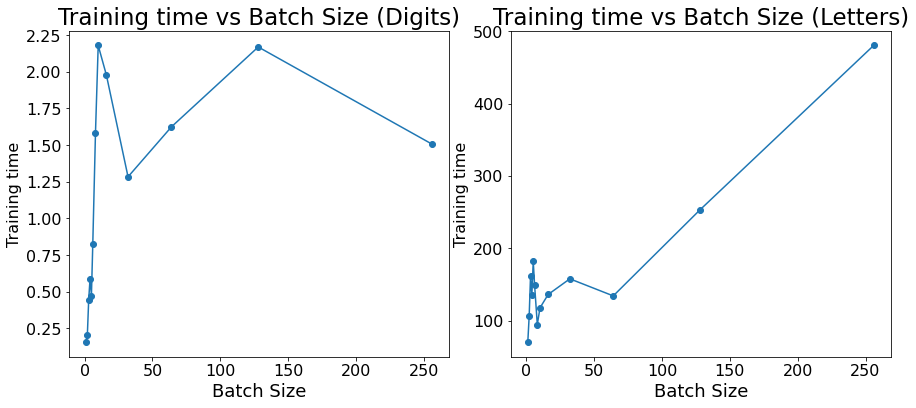

In [128]:
#set up for drawing
axes_digits, axes_letters = visualize('Batch Size', 'Training time')

#plot two graphs
axes_digits.plot(batchsize_optimiser_params_digits['batch_size'],running_times_digits, marker="o")
axes_letters.plot(batchsize_optimiser_params_letters['batch_size'],running_times_letters, marker="o")

##### Plotting Cost

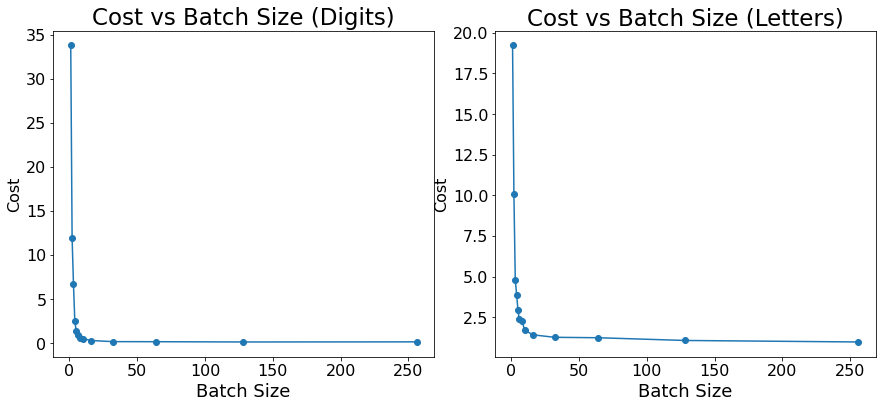

In [129]:
#set up for drawing
axes_digits, axes_letters = visualize('Batch Size', 'Cost')

##plot two graphs
axes_digits.plot(batchsize_optimiser_params_digits['batch_size'],costs_digits, marker="o")
axes_letters.plot(batchsize_optimiser_params_letters['batch_size'],costs_letters, marker="o")

#### Learning Rate Tuning

In [130]:
# Varying Initial learning Rate optimiser params
# Similarly, the reason we choose these learning_rates is we believe there is little change for larger batch sizes, so we increase their gap
learningrate_optimiser_params_digits={
    'inilearning_rate': [0.005, 0.01, 0.025, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9],
    
    'learning_rate_fn': None,
    'momentumbeta': best_optimiser_params_digits['momentumbeta'],
    'batch_size': best_optimiser_params_digits['batch_size'], 
    'max_iters': best_optimiser_params_digits['max_iters'], 
    'epsilon': best_optimiser_params_digits['epsilon'],
    'T': best_optimiser_params_digits['T'],
    'record_history': best_optimiser_params_digits['record_history']
}

learningrate_optimiser_params_letters={
    'inilearning_rate': [0.005, 0.01, 0.025, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9],
    'learning_rate_fn': None,
    'momentumbeta': best_optimiser_params_letters['momentumbeta'],
    'batch_size': best_optimiser_params_letters['batch_size'], 
    'max_iters': best_optimiser_params_letters['max_iters'], 
    'epsilon': best_optimiser_params_letters['epsilon'],
    'T': best_optimiser_params_letters['T'],
    'record_history': best_optimiser_params_letters['record_history']
}

##### Training

Note: This code block takes some time to run - Especially due to m10 learning rate function ( x/T )

In [131]:
# Constant Learning Rate, alpha = x0
learningrate_optimiser_params_digits['learning_rate_fn'] = learning_rate_const
_,_, training_accuracies_const_digits, validation_accuracies_const_digits, running_times_const_digits, costs_const_digits = grid_search_softmax_regressor(learningrate_optimiser_params_digits,digits_c,digits_x,digits_y, display = True)

# Decreasing Learning Rate, alpha = x0/T**0.5
learningrate_optimiser_params_digits['learning_rate_fn'] = learning_rate_m05
_,_, training_accuracies_m05_digits, validation_accuracies_m05_digits, running_times_m05_digits, costs_m05_digits = grid_search_softmax_regressor(learningrate_optimiser_params_digits,digits_c,digits_x,digits_y, display = True)

# Decreasing Learning Rate, alpha = x0/T**0.7
learningrate_optimiser_params_digits['learning_rate_fn'] = learning_rate_m07
_,_, training_accuracies_m07_digits, validation_accuracies_m07_digits, running_times_m07_digits, costs_m07_digits = grid_search_softmax_regressor(learningrate_optimiser_params_digits,digits_c,digits_x,digits_y, display = True)

# Decreasing Learning Rate, alpha = x0/T
learningrate_optimiser_params_digits['learning_rate_fn'] = learning_rate_m10
_,_, training_accuracies_m10_digits, validation_accuracies_m10_digits, running_times_m10_digits, costs_m10_digits = grid_search_softmax_regressor(learningrate_optimiser_params_digits,digits_c,digits_x,digits_y, display = True)


<ipython-input-118-d3bb35c64e88>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'inilearning_rate': 0.005
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 98.17765724644624%
 Validation Accuracy: 97.44073042401735%
 Run time: 8.458923578262329 seconds
 Cost: 0.13923042460053428

--- HYPERPARAMETERS COMBINATION 1 ---

'inilearning_rate': 0.01
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 98.31677801942116%
 Validation Accuracy: 97.32838130609719%
 Run time: 5.83957839012146 seconds
 Cost: 0.13523860090241163

--- HYPERPARAMETERS COMBINATION 2 ---

'inilearning_rate': 0.025
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100

--- HYPERPARAMETERS COMBINATION 7 ---

'inilearning_rate': 0.2
'learning_rate_fn': <function learning_rate_m05 at 0x000002EF4B616040>
'momentumbeta': 0.85
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 98.27529536789964%
 Validation Accuracy: 96.82729805013928%
 Run time: 14.170207500457764 seconds
 Cost: 0.15964868245419123

--- HYPERPARAMETERS COMBINATION 8 ---

'inilearning_rate': 0.3
'learning_rate_fn': <function learning_rate_m05 at 0x000002EF4B616040>
'momentumbeta': 0.85
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 97.57942050110191%
 Validation Accuracy: 96.0490560198081%
 Run time: 1.15423583984375 seconds
 Cost: 0.2293558349543748

--- HYPERPARAMETERS COMBINATION 9 ---

'inilearning_rate': 0.4
'learning_rate_fn': <function learning_rate_m05 at 0x000002EF4B616040>
'momentumbeta': 0.85
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_his

--- HYPERPARAMETERS COMBINATION 14 ---

'inilearning_rate': 0.9
'learning_rate_fn': <function learning_rate_m07 at 0x000002EF4B6C50D0>
'momentumbeta': 0.85
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 96.81412074877832%
 Validation Accuracy: 95.32528628907458%
 Run time: 4.649775981903076 seconds
 Cost: 0.5668831799934122

--- HYPERPARAMETERS COMBINATION 0 ---

'inilearning_rate': 0.005
'learning_rate_fn': <function learning_rate_m10 at 0x000002EF50FF1550>
'momentumbeta': 0.85
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 88.59192240053503%
 Validation Accuracy: 88.48050139275767%
 Run time: 10.345226049423218 seconds
 Cost: 1.6167540749327707

--- HYPERPARAMETERS COMBINATION 1 ---

'inilearning_rate': 0.01
'learning_rate_fn': <function learning_rate_m10 at 0x000002EF50FF1550>
'momentumbeta': 0.85
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'recor

In [132]:
# Constant Learning Rate, alpha = x0
learningrate_optimiser_params_letters['learning_rate_fn'] = learning_rate_const
_,_, training_accuracies_const_letters, validation_accuracies_const_letters, running_times_const_letters, costs_const_letters = grid_search_softmax_regressor(learningrate_optimiser_params_letters,letters_c,letters_x, letters_y, display = True)

# Decreasing Learning Rate, alpha = x0/T**0.5
learningrate_optimiser_params_letters['learning_rate_fn'] = learning_rate_m05
_,_, training_accuracies_m05_letters, validation_accuracies_m05_letters, running_times_m05_letters, costs_m05_letters = grid_search_softmax_regressor(learningrate_optimiser_params_letters,letters_c,letters_x,letters_y, display = True)

# Decreasing Learning Rate, alpha = x0/T**0.7
learningrate_optimiser_params_letters['learning_rate_fn'] = learning_rate_m07
_,_, training_accuracies_m07_letters, validation_accuracies_m07_letters, running_times_m07_letters, costs_m07_letters = grid_search_softmax_regressor(learningrate_optimiser_params_letters,letters_c,letters_x,letters_y, display = True)

# Decreasing Learning Rate, alpha = x0/T
learningrate_optimiser_params_letters['learning_rate_fn'] = learning_rate_m10
_,_, training_accuracies_m10_letters, validation_accuracies_m10_letters, running_times_m10_letters, costs_m10_letters = grid_search_softmax_regressor(learningrate_optimiser_params_letters,letters_c,letters_x,letters_y, display = True)


<ipython-input-118-d3bb35c64e88>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'inilearning_rate': 0.005
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 56.22125%
 Validation Accuracy: 56.28500000000001%
 Run time: 162.7261266708374 seconds
 Cost: 2.286875583417324

--- HYPERPARAMETERS COMBINATION 1 ---

'inilearning_rate': 0.01
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 69.07875%
 Validation Accuracy: 69.06%
 Run time: 469.40599489212036 seconds
 Cost: 1.356836494836915

--- HYPERPARAMETERS COMBINATION 2 ---

'inilearning_rate': 0.025
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Tr

--- HYPERPARAMETERS COMBINATION 7 ---

'inilearning_rate': 0.2
'learning_rate_fn': <function learning_rate_m05 at 0x000002EF4B616040>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 67.57125%
 Validation Accuracy: 67.46000000000001%
 Run time: 241.21165704727173 seconds
 Cost: 1.4496966418996515

--- HYPERPARAMETERS COMBINATION 8 ---

'inilearning_rate': 0.3
'learning_rate_fn': <function learning_rate_m05 at 0x000002EF4B616040>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 69.25125000000001%
 Validation Accuracy: 69.215%
 Run time: 209.65579104423523 seconds
 Cost: 1.3534315281472702

--- HYPERPARAMETERS COMBINATION 9 ---

'inilearning_rate': 0.4
'learning_rate_fn': <function learning_rate_m05 at 0x000002EF4B616040>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 

--- HYPERPARAMETERS COMBINATION 14 ---

'inilearning_rate': 0.9
'learning_rate_fn': <function learning_rate_m07 at 0x000002EF4B6C50D0>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 69.21%
 Validation Accuracy: 69.14999999999999%
 Run time: 158.22778749465942 seconds
 Cost: 1.3323621176156037

--- HYPERPARAMETERS COMBINATION 0 ---

'inilearning_rate': 0.005
'learning_rate_fn': <function learning_rate_m10 at 0x000002EF50FF1550>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 19.516250000000003%
 Validation Accuracy: 19.160000000000004%
 Run time: 106.45161724090576 seconds
 Cost: 3.2376809378257034

--- HYPERPARAMETERS COMBINATION 1 ---

'inilearning_rate': 0.01
'learning_rate_fn': <function learning_rate_m10 at 0x000002EF50FF1550>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_hist

##### Plotting Accuracies

Plotting Training and validation accuracies vs initial learning rate for each learning function on separate graphs ( Also separately for each dataset )

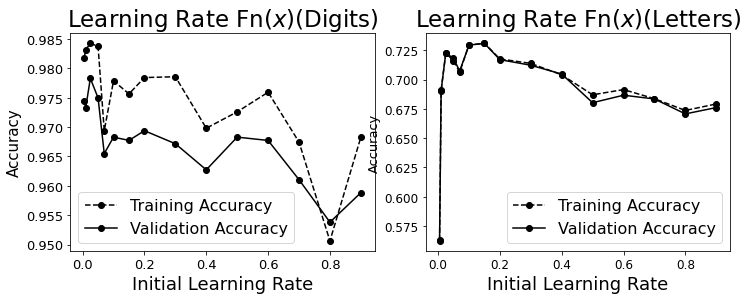

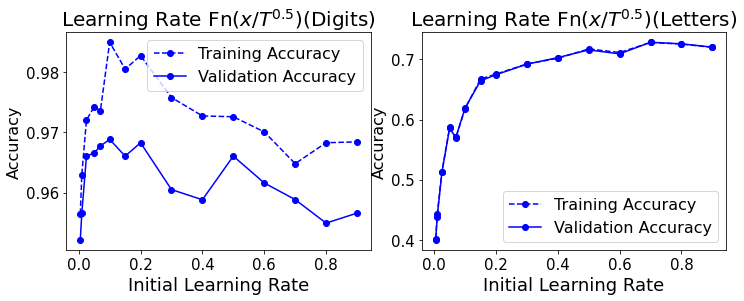

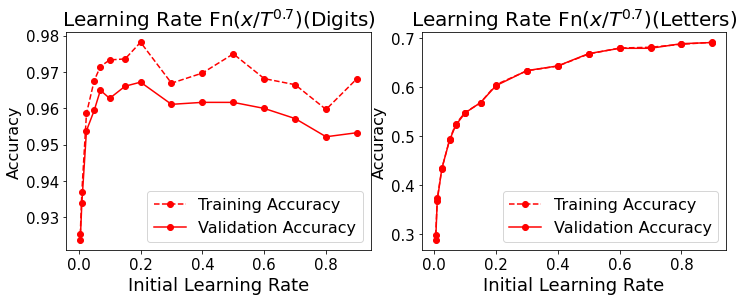

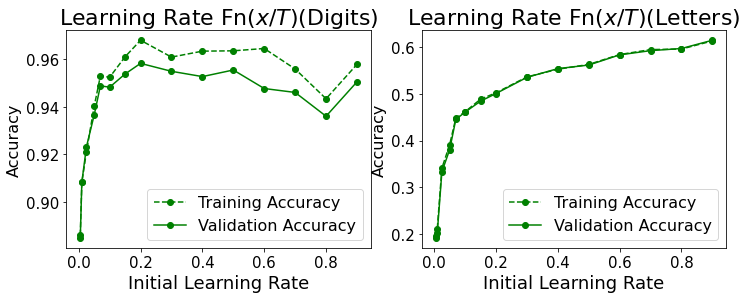

In [180]:
# Plotting accuracies for Constant Learning Rate, alpha = x0
fig, (axes_const_digits,axes_const_letters) = plt.subplots(1,2)

chartBox = axes_const_digits.get_position()
axes_const_digits.set_position([chartBox.x0, chartBox.y0, 
                 chartBox.width*2, 
                 chartBox.height]) 
chartBox = axes_const_letters.get_position() 
axes_const_letters.set_position([0.4+chartBox.x0, chartBox.y0, 
                 chartBox.width*2, 
                 chartBox.height]) 

axes_const_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],training_accuracies_const_digits, label= "Training Accuracy" ,marker="o", linestyle="--", color="black")
axes_const_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],validation_accuracies_const_digits, label= "Validation Accuracy", marker="o", color="black")

axes_const_digits.set_ylabel("Accuracy")
axes_const_digits.set_xlabel("Initial Learning Rate")
axes_const_digits.set_title("Learning Rate Fn($x$)(Digits)")

axes_const_digits.title.set_size(23)
axes_const_digits.xaxis.label.set_size(18)
axes_const_digits.yaxis.label.set_size(15)
axes_const_digits.tick_params(axis = 'both', which = 'major', labelsize = 13)
axes_const_digits.legend(fontsize=16)



axes_const_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],training_accuracies_const_letters, label= "Training Accuracy" ,marker="o", linestyle="--", color="black")
axes_const_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],validation_accuracies_const_letters, label= "Validation Accuracy", marker="o", color="black")

axes_const_letters.set_ylabel("Accuracy")
axes_const_letters.set_xlabel("Initial Learning Rate")
axes_const_letters.set_title("Learning Rate Fn($x$)(Letters)")
axes_const_letters.title.set_size(23)
axes_const_letters.xaxis.label.set_size(18)
axes_const_letters.yaxis.label.set_size(13)
axes_const_letters.tick_params(axis = 'both', which = 'major', labelsize = 12)
axes_const_letters.legend(fontsize=16)

# Plotting accuracies for Decreasing Learning Rate, alpha = x0/T**0.5
fig, (axes_m05_digits,axes_m05_letters) = plt.subplots(1,2)

chartBox = axes_m05_digits.get_position()
axes_m05_digits.set_position([chartBox.x0, chartBox.y0, 
                 chartBox.width*2, 
                 chartBox.height]) 
chartBox = axes_m05_letters.get_position() 
axes_m05_letters.set_position([0.4+chartBox.x0, chartBox.y0, 
                 chartBox.width*2, 
                 chartBox.height]) 

axes_m05_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],training_accuracies_m05_digits, label= "Training Accuracy", marker="o", linestyle="--", color="blue")
axes_m05_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],validation_accuracies_m05_digits, label= "Validation Accuracy", marker="o", color="blue")

axes_m05_digits.set_ylabel("Accuracy")
axes_m05_digits.set_xlabel("Initial Learning Rate")
axes_m05_digits.set_title("Learning Rate Fn($x/T^{0.5}$)(Digits)")
axes_m05_digits.title.set_size(20)
axes_m05_digits.xaxis.label.set_size(18)
axes_m05_digits.yaxis.label.set_size(16)
axes_m05_digits.tick_params(axis = 'both', which = 'major', labelsize = 15)
axes_m05_digits.legend(fontsize=16)

axes_m05_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],training_accuracies_m05_letters, label= "Training Accuracy", marker="o", linestyle="--", color="blue")
axes_m05_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],validation_accuracies_m05_letters, label= "Validation Accuracy", marker="o", color="blue")

axes_m05_letters.set_ylabel("Accuracy")
axes_m05_letters.set_xlabel("Initial Learning Rate")
axes_m05_letters.set_title("Learning Rate Fn($x/T^{0.5}$)(Letters)")
axes_m05_letters.title.set_size(20)
axes_m05_letters.xaxis.label.set_size(18)
axes_m05_letters.yaxis.label.set_size(16)
axes_m05_letters.tick_params(axis = 'both', which = 'major', labelsize = 15)
axes_m05_letters.legend(fontsize=16)

# Plotting accuracies for Decreasing Learning Rate, alpha = x0/T**0.7
fig, (axes_m07_digits,axes_m07_letters) = plt.subplots(1,2)

chartBox = axes_m07_digits.get_position()
axes_m07_digits.set_position([chartBox.x0, chartBox.y0, 
                 chartBox.width*2, 
                 chartBox.height]) 
chartBox = axes_m07_letters.get_position() 
axes_m07_letters.set_position([0.4+chartBox.x0, chartBox.y0, 
                 chartBox.width*2, 
                 chartBox.height]) 

axes_m07_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],training_accuracies_m07_digits, label= "Training Accuracy" , marker="o", linestyle="--", color="red")
axes_m07_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],validation_accuracies_m07_digits, label= "Validation Accuracy", marker="o", color="red")

axes_m07_digits.set_ylabel("Accuracy")
axes_m07_digits.set_xlabel("Initial Learning Rate")
axes_m07_digits.set_title("Learning Rate Fn($x/T^{0.7}$)(Digits)")
axes_m07_digits.title.set_size(20)
axes_m07_digits.xaxis.label.set_size(18)
axes_m07_digits.yaxis.label.set_size(16)
axes_m07_digits.tick_params(axis = 'both', which = 'major', labelsize = 15)
axes_m07_digits.legend(fontsize=16)

axes_m07_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],training_accuracies_m07_letters, label= "Training Accuracy" , marker="o", linestyle="--", color="red")
axes_m07_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],validation_accuracies_m07_letters, label= "Validation Accuracy", marker="o", color="red")

axes_m07_letters.set_ylabel("Accuracy")
axes_m07_letters.set_xlabel("Initial Learning Rate")
axes_m07_letters.set_title("Learning Rate Fn($x/T^{0.7}$)(Letters)")
axes_m07_letters.title.set_size(20)
axes_m07_letters.xaxis.label.set_size(18)
axes_m07_letters.yaxis.label.set_size(16)
axes_m07_letters.tick_params(axis = 'both', which = 'major', labelsize = 15)
axes_m07_letters.legend(fontsize=16)

# Plotting accuracies for Decreasing Learning Rate, alpha = x0/T
fig, (axes_m10_digits,axes_m10_letters) = plt.subplots(1,2)

chartBox = axes_m10_digits.get_position()
axes_m10_digits.set_position([chartBox.x0, chartBox.y0, 
                 chartBox.width*2, 
                 chartBox.height]) 
chartBox = axes_m10_letters.get_position() 
axes_m10_letters.set_position([0.4+chartBox.x0, chartBox.y0, 
                 chartBox.width*2, 
                 chartBox.height]) 

axes_m10_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],training_accuracies_m10_digits, label= "Training Accuracy" , marker="o", linestyle="--", color="green")
axes_m10_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],validation_accuracies_m10_digits, label= "Validation Accuracy", marker="o", color="green")

axes_m10_digits.set_ylabel("Accuracy")
axes_m10_digits.set_xlabel("Initial Learning Rate")
axes_m10_digits.set_title("Learning Rate Fn($x/T$)(Digits)")
axes_m10_digits.title.set_size(22)
axes_m10_digits.xaxis.label.set_size(18)
axes_m10_digits.yaxis.label.set_size(16)
axes_m10_digits.tick_params(axis = 'both', which = 'major', labelsize = 15)
axes_m10_digits.legend(fontsize=16)

axes_m10_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],training_accuracies_m10_letters, label= "Training Accuracy" , marker="o", linestyle="--", color="green")
axes_m10_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],validation_accuracies_m10_letters, label= "Validation Accuracy", marker="o", color="green")

axes_m10_letters.set_ylabel("Accuracy")
axes_m10_letters.set_xlabel("Initial Learning Rate")
axes_m10_letters.set_title("Learning Rate Fn($x/T$)(Letters)")
axes_m10_letters.title.set_size(22)
axes_m10_letters.xaxis.label.set_size(18)
axes_m10_letters.yaxis.label.set_size(16)
axes_m10_letters.tick_params(axis = 'both', which = 'major', labelsize = 15)
axes_m10_letters.legend(fontsize=16)



Plotting Training accuracy vs initial learning rate for each learning function on the same graph ( separately for each dataset )



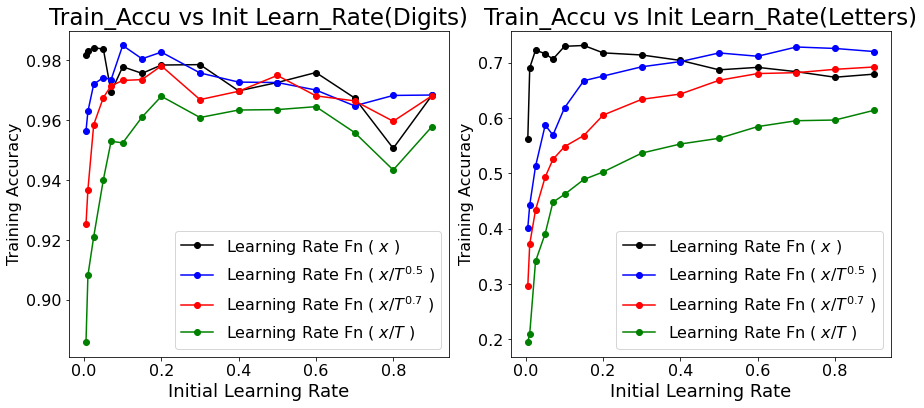

In [181]:
fig, ( training_axes_digits, training_axes_letters ) = plt.subplots(1,2)

chartBox = training_axes_digits.get_position()
training_axes_digits.set_position([chartBox.x0, chartBox.y0, 
                 chartBox.width*2.5, 
                 chartBox.height*1.5]) 
chartBox = training_axes_letters.get_position() 
training_axes_letters.set_position([0.6+chartBox.x0, chartBox.y0, 
                 chartBox.width*2.5, 
                 chartBox.height*1.5]) 

# Plotting running times for Constant Learning Rate, alpha = x0
training_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],training_accuracies_const_digits, label= "Learning Rate Fn ( $x$ )" ,marker="o", color="black")
training_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],training_accuracies_const_letters, label= "Learning Rate Fn ( $x$ )" ,marker="o", color="black")
# Plotting running times for Decreasing Learning Rate, alpha = x0/T**0.5
training_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],training_accuracies_m05_digits,  label= "Learning Rate Fn ( $x/T^{0.5}$ )" ,marker="o", color="blue")
training_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],training_accuracies_m05_letters,  label= "Learning Rate Fn ( $x/T^{0.5}$ )" ,marker="o", color="blue")
# Plotting running times for Decreasing Learning Rate, alpha = x0/T**0.7
training_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],training_accuracies_m07_digits,  label= "Learning Rate Fn ( $x/T^{0.7}$ )" ,marker="o", color="red")
training_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],training_accuracies_m07_letters,  label= "Learning Rate Fn ( $x/T^{0.7}$ )" ,marker="o", color="red")
# Plotting running times for Decreasing Learning Rate, alpha = x0/T
training_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],training_accuracies_m10_digits,  label= "Learning Rate Fn ( $x/T$ )" ,marker="o", color="green")
training_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],training_accuracies_m10_letters,  label= "Learning Rate Fn ( $x/T$ )" ,marker="o", color="green")

training_axes_digits.set_title("Train_Accu vs Init Learn_Rate(Digits)")
training_axes_digits.set_xlabel("Initial Learning Rate")
training_axes_digits.set_ylabel("Training Accuracy")
training_axes_digits.title.set_size(23)
training_axes_digits.xaxis.label.set_size(18)
training_axes_digits.yaxis.label.set_size(16)
training_axes_digits.tick_params(axis = 'both', which = 'major', labelsize = 16)
training_axes_digits.legend(fontsize=16)


training_axes_letters.set_title("Train_Accu vs Init Learn_Rate(Letters)")
training_axes_letters.set_xlabel("Initial Learning Rate")
training_axes_letters.set_ylabel("Training Accuracy")
training_axes_letters.title.set_size(23)
training_axes_letters.xaxis.label.set_size(18)
training_axes_letters.yaxis.label.set_size(16)
training_axes_letters.tick_params(axis = 'both', which = 'major', labelsize = 16)
training_axes_letters.legend(fontsize=16)

Plotting Validation accuracy vs initial learning rate for each learning function ( separately for each dataset )

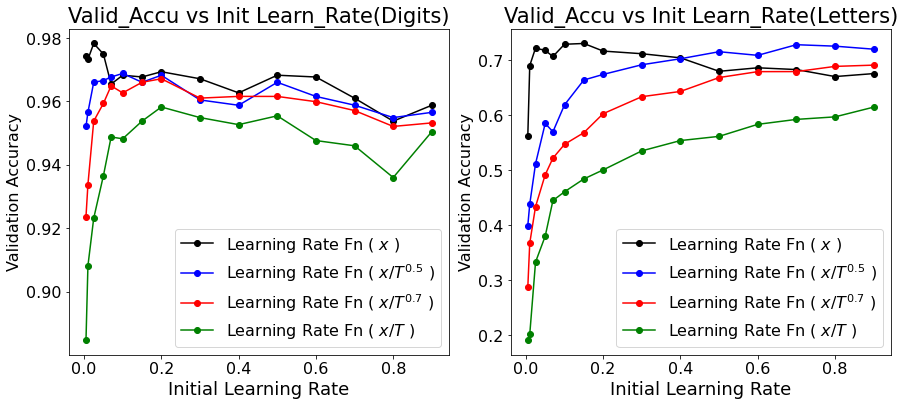

In [182]:
fig, ( validation_axes_digits, validation_axes_letters ) = plt.subplots(1,2)

chartBox = validation_axes_digits.get_position()
validation_axes_digits.set_position([chartBox.x0, chartBox.y0, 
                 chartBox.width*2.5, 
                 chartBox.height*1.5]) 
chartBox = validation_axes_letters.get_position() 
validation_axes_letters.set_position([0.6+chartBox.x0, chartBox.y0, 
                 chartBox.width*2.5, 
                 chartBox.height*1.5]) 

# Plotting running times for Constant Learning Rate, alpha = x0
validation_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],validation_accuracies_const_digits, label= "Learning Rate Fn ( $x$ )" ,marker="o", color="black")
validation_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],validation_accuracies_const_letters, label= "Learning Rate Fn ( $x$ )" ,marker="o", color="black")
# Plotting running times for Decreasing Learning Rate, alpha = x0/T**0.5
validation_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],validation_accuracies_m05_digits,  label= "Learning Rate Fn ( $x/T^{0.5}$ )" ,marker="o", color="blue")
validation_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],validation_accuracies_m05_letters,  label= "Learning Rate Fn ( $x/T^{0.5}$ )" ,marker="o", color="blue")
# Plotting running times for Decreasing Learning Rate, alpha = x0/T**0.7
validation_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],validation_accuracies_m07_digits,  label= "Learning Rate Fn ( $x/T^{0.7}$ )" ,marker="o", color="red")
validation_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],validation_accuracies_m07_letters,  label= "Learning Rate Fn ( $x/T^{0.7}$ )" ,marker="o", color="red")
# Plotting running times for Decreasing Learning Rate, alpha = x0/T
validation_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],validation_accuracies_m10_digits,  label= "Learning Rate Fn ( $x/T$ )" ,marker="o", color="green")
validation_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],validation_accuracies_m10_letters,  label= "Learning Rate Fn ( $x/T$ )" ,marker="o", color="green")

validation_axes_digits.set_title("Valid_Accu vs Init Learn_Rate(Digits)")
validation_axes_digits.set_xlabel("Initial Learning Rate")
validation_axes_digits.set_ylabel("Validation Accuracy")
validation_axes_digits.title.set_size(21)
validation_axes_digits.xaxis.label.set_size(18)
validation_axes_digits.yaxis.label.set_size(16)
validation_axes_digits.tick_params(axis = 'both', which = 'major', labelsize = 16)
validation_axes_digits.legend(fontsize=16)

validation_axes_letters.set_title("Valid_Accu vs Init Learn_Rate(Letters)")
validation_axes_letters.set_xlabel("Initial Learning Rate")
validation_axes_letters.set_ylabel("Validation Accuracy")
validation_axes_letters.title.set_size(21)
validation_axes_letters.xaxis.label.set_size(18)
validation_axes_letters.yaxis.label.set_size(16)
validation_axes_letters.tick_params(axis = 'both', which = 'major', labelsize = 16)
validation_axes_letters.legend(fontsize=16)

##### Plotting Running Time

Plotting running time vs initial learning rate for all learning rate functions on the same graph ( Separate for each dataset )

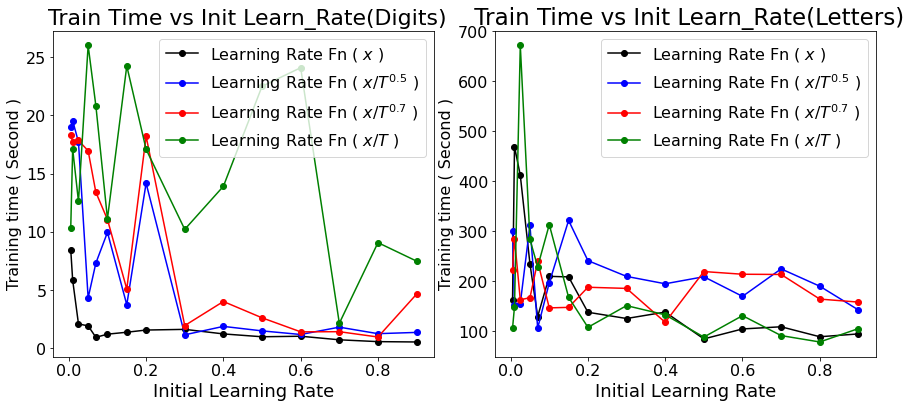

In [188]:
fig, ( runtime_axes_digits, runtime_axes_letters ) = plt.subplots(1,2)

chartBox = runtime_axes_digits.get_position()
runtime_axes_digits.set_position([chartBox.x0, chartBox.y0, 
                 chartBox.width*2.5, 
                 chartBox.height*1.5]) 
chartBox = runtime_axes_letters.get_position() 
runtime_axes_letters.set_position([0.6+chartBox.x0, chartBox.y0, 
                 chartBox.width*2.5, 
                 chartBox.height*1.5]) 

# Plotting running times for Constant Learning Rate, alpha = x0
runtime_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],running_times_const_digits, label= "Learning Rate Fn ( $x$ )" ,marker="o", color="black")
runtime_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],running_times_const_letters, label= "Learning Rate Fn ( $x$ )" ,marker="o", color="black")
# Plotting running times for Decreasing Learning Rate, alpha = x0/T**0.5
runtime_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],running_times_m05_digits,  label= "Learning Rate Fn ( $x/T^{0.5}$ )" ,marker="o", color="blue")
runtime_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],running_times_m05_letters,  label= "Learning Rate Fn ( $x/T^{0.5}$ )" ,marker="o", color="blue")
# Plotting running times for Decreasing Learning Rate, alpha = x0/T**0.7
runtime_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],running_times_m07_digits,  label= "Learning Rate Fn ( $x/T^{0.7}$ )" ,marker="o", color="red")
runtime_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],running_times_m07_letters,  label= "Learning Rate Fn ( $x/T^{0.7}$ )" ,marker="o", color="red")
# Plotting running times for Decreasing Learning Rate, alpha = x0/T
runtime_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],running_times_m10_digits,  label= "Learning Rate Fn ( $x/T$ )" ,marker="o", color="green")
runtime_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],running_times_m10_letters,  label= "Learning Rate Fn ( $x/T$ )" ,marker="o", color="green")

runtime_axes_digits.set_title(" Train Time vs Init Learn_Rate(Digits)")
runtime_axes_digits.set_xlabel("Initial Learning Rate")
runtime_axes_digits.set_ylabel("Training time ( Second )")
runtime_axes_digits.title.set_size(22)
runtime_axes_digits.xaxis.label.set_size(18)
runtime_axes_digits.yaxis.label.set_size(16)
runtime_axes_digits.tick_params(axis = 'both', which = 'major', labelsize = 16)
runtime_axes_digits.legend(fontsize=16)

runtime_axes_letters.set_title(" Train Time vs Init Learn_Rate(Letters)")
runtime_axes_letters.set_xlabel("Initial Learning Rate")
runtime_axes_letters.set_ylabel("Training time ( Second )")
runtime_axes_letters.title.set_size(23)
runtime_axes_letters.xaxis.label.set_size(18)
runtime_axes_letters.yaxis.label.set_size(16)
runtime_axes_letters.tick_params(axis = 'both', which = 'major', labelsize = 16)
runtime_axes_letters.legend(fontsize=16)

##### Plotting Cost

Plotting cost vs initial learning rate for all learning rate functions on the same graph ( Separate for each dataset )

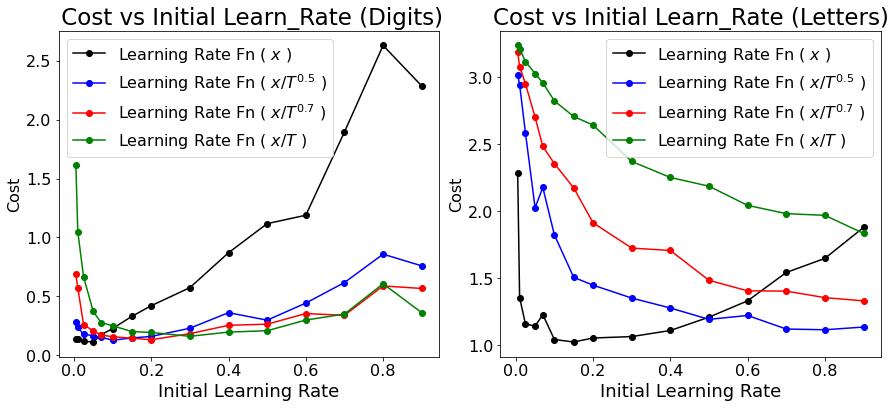

In [189]:
fig, ( cost_axes_digits, cost_axes_letters ) = plt.subplots(1,2)
 
chartBox = cost_axes_digits.get_position()
cost_axes_digits.set_position([chartBox.x0, chartBox.y0, 
                 chartBox.width*2.5, 
                 chartBox.height*1.5]) 
chartBox = cost_axes_letters.get_position() 
cost_axes_letters.set_position([0.6+chartBox.x0, chartBox.y0, 
                 chartBox.width*2.5, 
                 chartBox.height*1.5]) 
 
#cost_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],costs_letters, label= "Learning Rate Fn ( $x$ )" ,marker="o", color="black")
 
# Plotting running times for Constant Learning Rate, alpha = x0
cost_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],costs_const_digits, label= "Learning Rate Fn ( $x$ )" ,marker="o", color="black")
cost_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],costs_const_letters, label= "Learning Rate Fn ( $x$ )" ,marker="o", color="black")
# Plotting running times for Decreasing Learning Rate, alpha = x0/T**0.5
cost_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],costs_m05_digits,  label= "Learning Rate Fn ( $x/T^{0.5}$ )" ,marker="o", color="blue")
cost_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],costs_m05_letters,  label= "Learning Rate Fn ( $x/T^{0.5}$ )" ,marker="o", color="blue")
# Plotting running times for Decreasing Learning Rate, alpha = x0/T**0.7
cost_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],costs_m07_digits,  label= "Learning Rate Fn ( $x/T^{0.7}$ )" ,marker="o", color="red")
cost_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],costs_m07_letters,  label= "Learning Rate Fn ( $x/T^{0.7}$ )" ,marker="o", color="red")
# Plotting running times for Decreasing Learning Rate, alpha = x0/T
cost_axes_digits.plot(learningrate_optimiser_params_digits['inilearning_rate'],costs_m10_digits,  label= "Learning Rate Fn ( $x/T$ )" ,marker="o", color="green")
cost_axes_letters.plot(learningrate_optimiser_params_letters['inilearning_rate'],costs_m10_letters,  label= "Learning Rate Fn ( $x/T$ )" ,marker="o", color="green")
 
cost_axes_digits.set_title(" Cost vs Initial Learn_Rate (Digits)")
cost_axes_digits.set_xlabel("Initial Learning Rate")
cost_axes_digits.set_ylabel("Cost")
cost_axes_digits.title.set_size(23)
cost_axes_digits.xaxis.label.set_size(18)
cost_axes_digits.yaxis.label.set_size(16)
cost_axes_digits.tick_params(axis = 'both', which = 'major', labelsize = 16)
cost_axes_digits.legend(fontsize=16)
 
cost_axes_letters.set_title("Cost vs Initial Learn_Rate (Letters)")
cost_axes_letters.set_xlabel("Initial Learning Rate")
cost_axes_letters.set_ylabel("Cost")
cost_axes_letters.title.set_size(23)
cost_axes_letters.xaxis.label.set_size(18)
cost_axes_letters.yaxis.label.set_size(16)
cost_axes_letters.tick_params(axis = 'both', which = 'major', labelsize = 16)
cost_axes_letters.legend(fontsize=16)

#### Momentum Tuning

##### Training

In [190]:
# Varying momentum optimiser params
#the reason we choose these  momentum values is the default value is usually 0.9
momentum_optimiser_params_digits={
    'inilearning_rate': best_optimiser_params_digits['inilearning_rate'], 
    'learning_rate_fn': best_optimiser_params_digits['learning_rate_fn'],
    'momentumbeta': [0.6,0.7,0.8,0.85,0.9,0.925,0.95,0.99,0.999],
    'batch_size': best_optimiser_params_digits['batch_size'], 
    'max_iters': best_optimiser_params_digits['max_iters'], 
    'epsilon': best_optimiser_params_digits['epsilon'],
    'T': best_optimiser_params_digits['T'],
    'record_history': best_optimiser_params_digits['record_history']
}

momentum_optimiser_params_letters={
    'inilearning_rate': best_optimiser_params_letters['inilearning_rate'], 
    'learning_rate_fn': best_optimiser_params_letters['learning_rate_fn'],
    'momentumbeta': [0.6,0.7,0.8,0.85,0.9,0.925,0.95,0.99,0.999],
    'batch_size': best_optimiser_params_letters['batch_size'], 
    'max_iters': best_optimiser_params_letters['max_iters'], 
    'epsilon': best_optimiser_params_letters['epsilon'],
    'T': best_optimiser_params_letters['T'],
    'record_history': best_optimiser_params_letters['record_history']
}

In [191]:
_,_, training_accuracies_digits, validation_accuracies_digits, running_times_digits, costs_digits = grid_search_softmax_regressor(momentum_optimiser_params_digits,digits_c,digits_x,digits_y, display = True)

<ipython-input-118-d3bb35c64e88>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'inilearning_rate': 0.05
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.6
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 98.58114039544988%
 Validation Accuracy: 97.16279789538842%
 Run time: 3.8994040489196777 seconds
 Cost: 0.1334074957207993

--- HYPERPARAMETERS COMBINATION 1 ---

'inilearning_rate': 0.05
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.7
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 99.23479703407752%
 Validation Accuracy: 97.32760755184154%
 Run time: 6.944385528564453 seconds
 Cost: 0.13063834289361448

--- HYPERPARAMETERS COMBINATION 2 ---

'inilearning_rate': 0.05
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.8
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
're

In [192]:
_,_, training_accuracies_letters, validation_accuracies_letters, running_times_letters, costs_letters = grid_search_softmax_regressor(momentum_optimise
                                                                                                                                      r_params_letters,letters_c,letters_x,letters_y, display = True)

<ipython-input-118-d3bb35c64e88>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'inilearning_rate': 0.07
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.6
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 72.69375%
 Validation Accuracy: 72.78499999999998%
 Run time: 241.9621298313141 seconds
 Cost: 1.0922262225565986

--- HYPERPARAMETERS COMBINATION 1 ---

'inilearning_rate': 0.07
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.7
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 72.49125%
 Validation Accuracy: 72.62%
 Run time: 223.1274619102478 seconds
 Cost: 1.0924923435349125

--- HYPERPARAMETERS COMBINATION 2 ---

'inilearning_rate': 0.07
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.8
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Traini

##### Plotting Accuracies

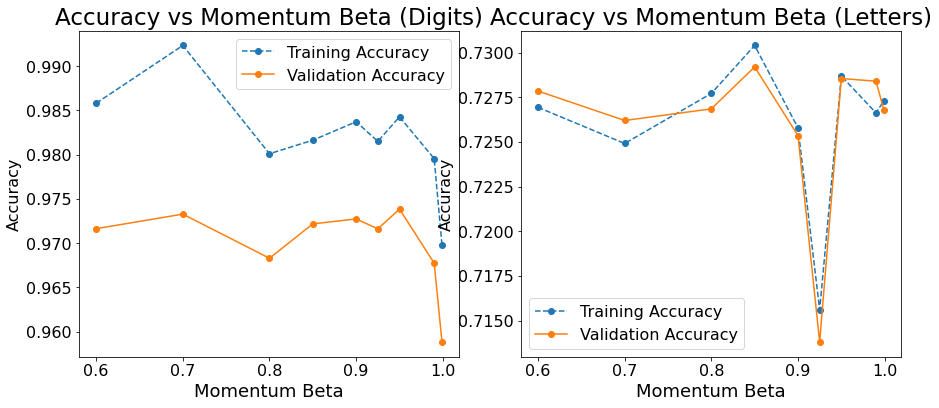

In [193]:
#set up
axes_digits, axes_letters = visualize('Momentum Beta', 'Accuracy')

#plotting digits
axes_digits.plot(momentum_optimiser_params_digits['momentumbeta'],training_accuracies_digits, label= "Training Accuracy ", linestyle="--", marker="o")
axes_digits.plot(momentum_optimiser_params_digits['momentumbeta'],validation_accuracies_digits, label = "Validation Accuracy", marker="o")

#plotting letters
axes_letters.plot(momentum_optimiser_params_letters['momentumbeta'],training_accuracies_letters, label= "Training Accuracy ", linestyle="--", marker="o")
axes_letters.plot(momentum_optimiser_params_letters['momentumbeta'],validation_accuracies_letters, label = "Validation Accuracy", marker="o")

#plotting legends
axes_digits.legend(fontsize=16)
axes_letters.legend(fontsize=16)

##### Plotting Running Time

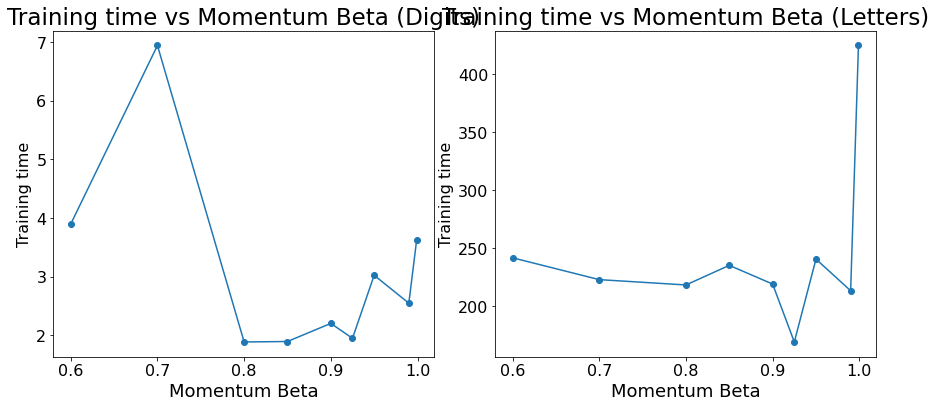

In [194]:
#set up
axes_digits, axes_letters = visualize('Momentum Beta', 'Training time')

#plot graphs
axes_digits.plot(momentum_optimiser_params_digits['momentumbeta'],running_times_digits, marker="o")
axes_letters.plot(momentum_optimiser_params_letters['momentumbeta'],running_times_letters, marker="o")

##### Plotting Cost

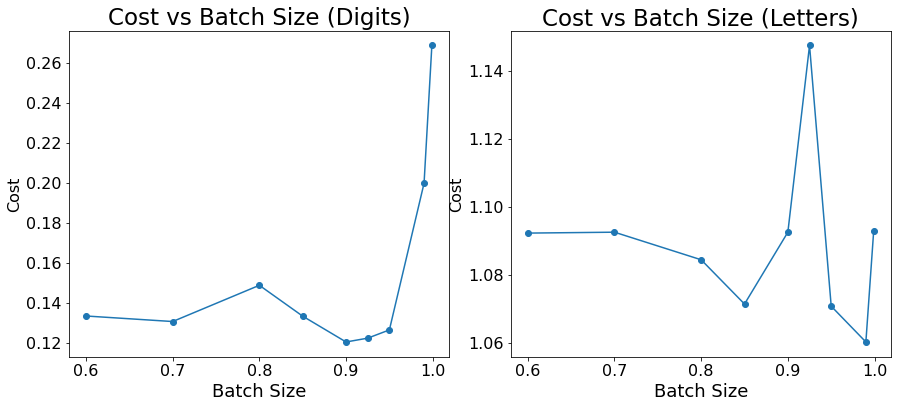

In [195]:
#set up
axes_digits, axes_letters = visualize('Batch Size', 'Cost')

#plotting graphs
axes_digits.plot(momentum_optimiser_params_digits['momentumbeta'],costs_digits, marker="o")
axes_letters.plot(momentum_optimiser_params_letters['momentumbeta'],costs_letters, marker="o")

#### RMS Tuning ( Extra - Adam GD )

##### Training

In [196]:
# Varying RMS optimiser params
#the reaosn we choose these values is that the default value is 0.999
rms_optimiser_params_digits={
    'inilearning_rate': best_optimiser_params_digits['inilearning_rate'], 
    'learning_rate_fn': best_optimiser_params_digits['learning_rate_fn'],
    'momentumbeta': best_optimiser_params_digits['momentumbeta'],
    'batch_size': best_optimiser_params_digits['batch_size'], 
    'max_iters': best_optimiser_params_digits['max_iters'], 
    'epsilon': best_optimiser_params_digits['epsilon'],
    'T': best_optimiser_params_digits['T'],
    'record_history': best_optimiser_params_digits['record_history'],
    'Lambda': 0,
    'RMSbeta': [0.98, 0.99, 0.999, 0.9999]
}

rms_optimiser_params_letters={
    'inilearning_rate': best_optimiser_params_letters['inilearning_rate'], 
    'learning_rate_fn': best_optimiser_params_letters['learning_rate_fn'],
    'momentumbeta': best_optimiser_params_letters['momentumbeta'],
    'batch_size': best_optimiser_params_letters['batch_size'], 
    'max_iters': best_optimiser_params_letters['max_iters'], 
    'epsilon': best_optimiser_params_letters['epsilon'],
    'T': best_optimiser_params_letters['T'],
    'record_history': best_optimiser_params_letters['record_history'],
    'Lambda': 0,
    'RMSbeta': [0.98, 0.99, 0.999, 0.9999]
}

"\nrms_optimiser_params_letters={\n    'inilearning_rate': best_optimiser_params_letters['inilearning_rate'], \n    'learning_rate_fn': best_optimiser_params_letters['learning_rate_fn'],\n    'momentumbeta': best_optimiser_params_letters['momentumbeta'],\n    'batch_size': best_optimiser_params_letters['batch_size'], \n    'max_iters': best_optimiser_params_letters['max_iters'], \n    'epsilon': best_optimiser_params_letters['epsilon'],\n    'T': best_optimiser_params_letters['T'],\n    'record_history': best_optimiser_params_letters['record_history'],\n    'Lambda': 0.2,\n    'RMSbeta': 0.999\n}\n"

In [197]:
_,_, training_accuracies_digits, validation_accuracies_digits, running_times_digits, costs_digits = grid_search_softmax_regressor_EXTRA(rms_optimiser_params_digits,digits_c,digits_x,digits_y, display = True)

<ipython-input-118-d3bb35c64e88>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'inilearning_rate': 0.05
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False
'Lambda': 0
'RMSbeta': 0.98

 Training Accuracy: 97.63479200118465%
 Validation Accuracy: 96.82822655524606%
 Run time: 1.5820722579956055 seconds
 Cost: 0.2871047027149543

--- HYPERPARAMETERS COMBINATION 1 ---

'inilearning_rate': 0.05
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False
'Lambda': 0
'RMSbeta': 0.99

 Training Accuracy: 97.50968589909243%
 Validation Accuracy: 96.43825441039925%
 Run time: 1.1164162158966064 seconds
 Cost: 0.2133482179907013

--- HYPERPARAMETERS COMBINATION 2 ---

'inilearning_rate': 0.05
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch

In [198]:
_,_, training_accuracies_letters, validation_accuracies_letters, running_times_letters, costs_letters = grid_search_softmax_regressor_EXTRA(rms_optimiser_params_letters,letters_c,letters_x,letters_y, display = True)

<ipython-input-118-d3bb35c64e88>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'inilearning_rate': 0.07
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False
'Lambda': 0
'RMSbeta': 0.98

 Training Accuracy: 69.63874999999999%
 Validation Accuracy: 70.015%
 Run time: 124.77858710289001 seconds
 Cost: 1.1272562233072079

--- HYPERPARAMETERS COMBINATION 1 ---

'inilearning_rate': 0.07
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False
'Lambda': 0
'RMSbeta': 0.99

 Training Accuracy: 69.43124999999999%
 Validation Accuracy: 69.52000000000001%
 Run time: 83.58667373657227 seconds
 Cost: 1.1591587530461205

--- HYPERPARAMETERS COMBINATION 2 ---

'inilearning_rate': 0.07
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 12

##### Plotting Accuracies

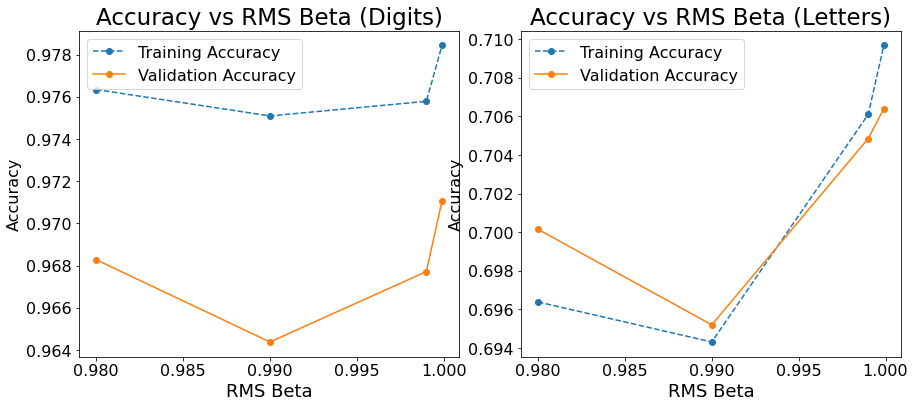

In [199]:
#set up
axes_digits, axes_letters = visualize('RMS Beta', 'Accuracy')

#plot digit graph
axes_digits.plot(rms_optimiser_params_digits['RMSbeta'],training_accuracies_digits, label= "Training Accuracy ", linestyle="--", marker="o")
axes_digits.plot(rms_optimiser_params_digits['RMSbeta'],validation_accuracies_digits, label = "Validation Accuracy", marker="o")

#plot letters graph
axes_letters.plot(rms_optimiser_params_letters['RMSbeta'],training_accuracies_letters, label= "Training Accuracy ", linestyle="--", marker="o")
axes_letters.plot(rms_optimiser_params_letters['RMSbeta'],validation_accuracies_letters, label = "Validation Accuracy", marker="o")

#plot legend
axes_digits.legend(fontsize=16)
axes_letters.legend(fontsize=16)

##### Plotting Training Time

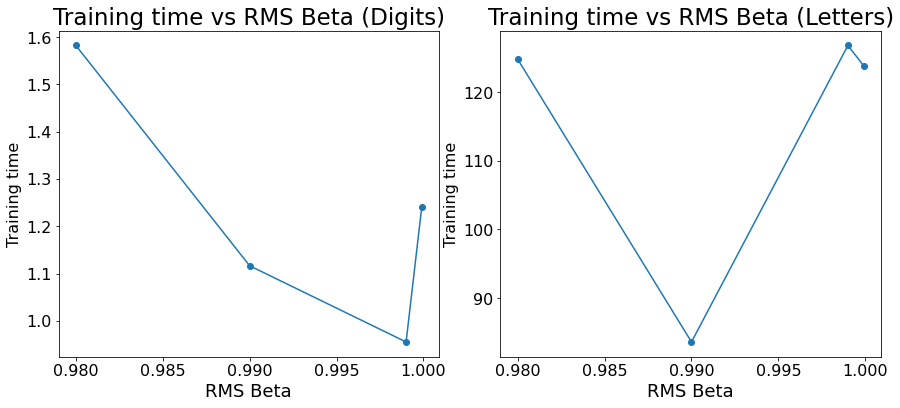

In [201]:
#set up
axes_digits, axes_letters = visualize('RMS Beta', 'Training time')

#plot graphs
axes_digits.plot(rms_optimiser_params_digits['RMSbeta'],running_times_digits, marker="o")
axes_letters.plot(rms_optimiser_params_letters['RMSbeta'],running_times_letters, marker="o")

##### Plotting Cost

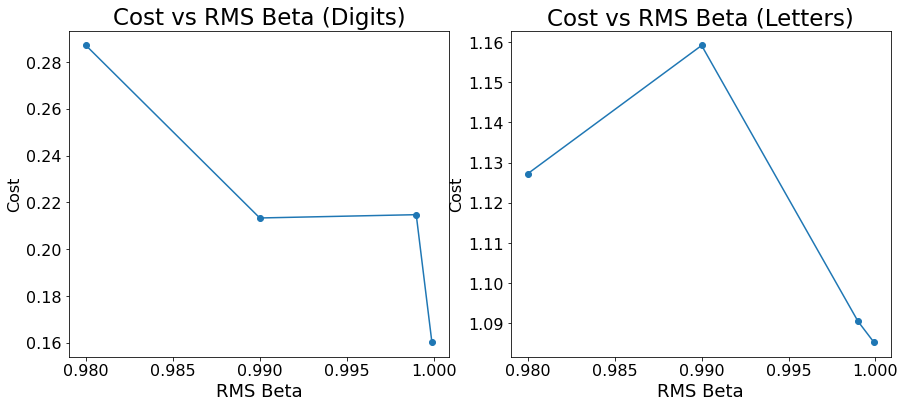

In [202]:
#set up
axes_digits, axes_letters = visualize('RMS Beta', 'Cost')

#plot graphs
axes_digits.plot(rms_optimiser_params_digits['RMSbeta'],costs_digits, marker="o")
axes_letters.plot(rms_optimiser_params_letters['RMSbeta'],costs_letters, marker="o")

#### Lambda Tuning ( Extra - Adam GD )

In [203]:
# Varying Regularization optimiser params
# The reason we choose these values is that we doubt there is necessary need for regularization, which is for preventing overfitting, so there is no higher values of lambda
lambda_optimiser_params_digits={
    'inilearning_rate': best_optimiser_params_digits['inilearning_rate'], 
    'learning_rate_fn': best_optimiser_params_digits['learning_rate_fn'],
    'momentumbeta': best_optimiser_params_digits['momentumbeta'],
    'batch_size': best_optimiser_params_digits['batch_size'], 
    'max_iters': best_optimiser_params_digits['max_iters'], 
    'epsilon': best_optimiser_params_digits['epsilon'],
    'T': best_optimiser_params_digits['T'],
    'record_history': best_optimiser_params_digits['record_history'],
    'Lambda': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9,1],
    'RMSbeta': 0.99
}

lambda_optimiser_params_letters={
    'inilearning_rate': best_optimiser_params_letters['inilearning_rate'], 
    'learning_rate_fn': best_optimiser_params_letters['learning_rate_fn'],
    'momentumbeta': best_optimiser_params_letters['momentumbeta'],
    'batch_size': best_optimiser_params_letters['batch_size'], 
    'max_iters': best_optimiser_params_letters['max_iters'], 
    'epsilon': best_optimiser_params_letters['epsilon'],
    'T': best_optimiser_params_letters['T'],
    'record_history': best_optimiser_params_letters['record_history'],
    'Lambda': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9,1],
    'RMSbeta': 0.99
}


###### Training

In [204]:
_,_, training_accuracies_digits, validation_accuracies_digits, running_times_digits, costs_digits = grid_search_softmax_regressor_EXTRA(lambda_optimiser_params_digits,digits_c,digits_x,digits_y, display = True)

<ipython-input-118-d3bb35c64e88>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'inilearning_rate': 0.05
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False
'Lambda': 0.0
'RMSbeta': 0.99

 Training Accuracy: 97.38450236787929%
 Validation Accuracy: 96.94011142061282%
 Run time: 0.8958561420440674 seconds
 Cost: 0.186939412442306

--- HYPERPARAMETERS COMBINATION 1 ---

'inilearning_rate': 0.05
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False
'Lambda': 0.1
'RMSbeta': 0.99

 Training Accuracy: 96.10458932078207%
 Validation Accuracy: 95.3254410399257%
 Run time: 1.030125379562378 seconds
 Cost: 0.17659046019337127

--- HYPERPARAMETERS COMBINATION 2 ---

'inilearning_rate': 0.05
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'bat

In [205]:
_,_, training_accuracies_letters, validation_accuracies_letters, running_times_letters, costs_letters = grid_search_softmax_regressor_EXTRA(lambda_optimiser_params_letters,letters_c,letters_x,letters_y, display = True)

<ipython-input-118-d3bb35c64e88>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'inilearning_rate': 0.07
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False
'Lambda': 0.0
'RMSbeta': 0.99

 Training Accuracy: 70.6375%
 Validation Accuracy: 70.38499999999999%
 Run time: 120.05281233787537 seconds
 Cost: 1.1002503836824429

--- HYPERPARAMETERS COMBINATION 1 ---

'inilearning_rate': 0.07
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False
'Lambda': 0.1
'RMSbeta': 0.99

 Training Accuracy: 54.715%
 Validation Accuracy: 54.75%
 Run time: 62.079378604888916 seconds
 Cost: 1.7918062402685346

--- HYPERPARAMETERS COMBINATION 2 ---

'inilearning_rate': 0.07
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10

##### Plotting Accuracies

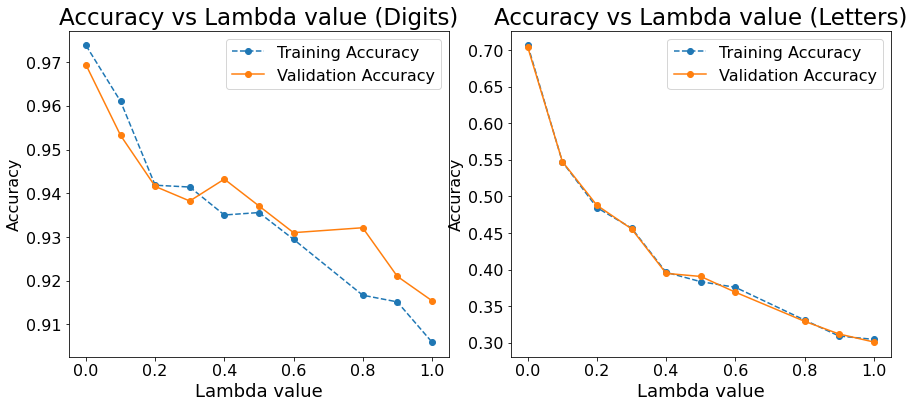

In [206]:
#set up
axes_digits, axes_letters = visualize('Lambda value', 'Accuracy')

#plot digit graph
axes_digits.plot(lambda_optimiser_params_digits['Lambda'],training_accuracies_digits, label= "Training Accuracy ", linestyle="--", marker="o")
axes_digits.plot(lambda_optimiser_params_digits['Lambda'],validation_accuracies_digits, label = "Validation Accuracy", marker="o")

#plot letter graph
axes_letters.plot(lambda_optimiser_params_letters['Lambda'],training_accuracies_letters, label= "Training Accuracy ", linestyle="--", marker="o")
axes_letters.plot(lambda_optimiser_params_letters['Lambda'],validation_accuracies_letters, label = "Validation Accuracy", marker="o")

#plot legends
axes_digits.legend(fontsize=16)
axes_letters.legend(fontsize=16)

##### Plotting Running time

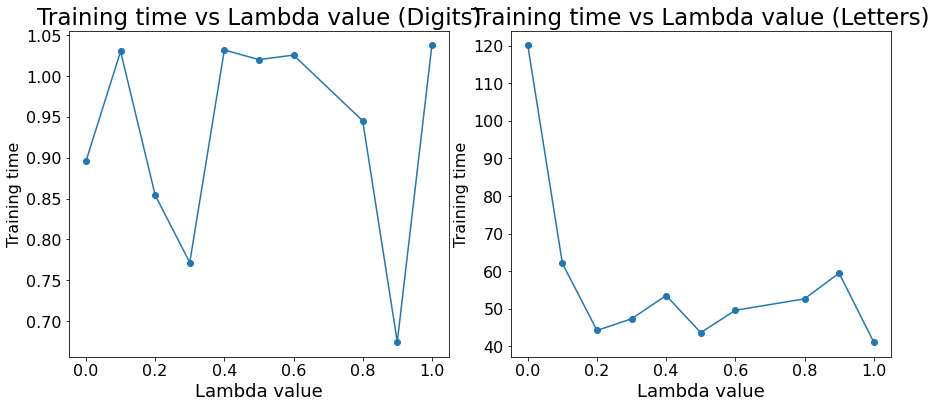

In [207]:
#set up
axes_digits, axes_letters = visualize('Lambda value', 'Training time')

#plot graphs
axes_digits.plot(lambda_optimiser_params_digits['Lambda'],running_times_digits, marker="o")
axes_letters.plot(lambda_optimiser_params_letters['Lambda'],running_times_letters, marker="o")

##### Plotting Cost

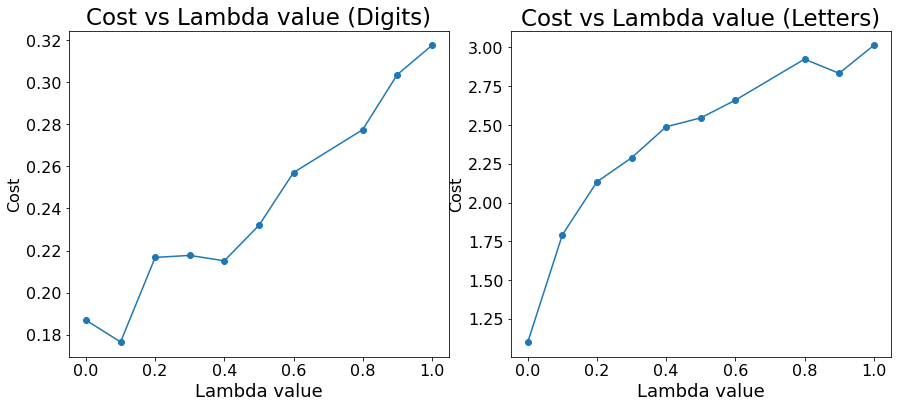

In [208]:
#set up
axes_digits, axes_letters = visualize('Lambda value', 'Cost')

#plot graphs
axes_digits.plot(lambda_optimiser_params_digits['Lambda'],costs_digits, marker="o")
axes_letters.plot(lambda_optimiser_params_letters['Lambda'],costs_letters, marker="o")

### Comparison with K-Nearest Neighbour Classifier

Fetching Datasets again ( without one-hot encoding )

In [209]:
digits_x_knn, digits_y_knn = load_digits(n_class=10,return_X_y=True)
digits_c_knn = 10

letters_x_knn, letters_y_knn = fetch_openml(data_id=6, return_X_y=True)
letters_c = 26

#### Implementation of Grid Search for KNN

In [210]:
def grid_search_knn(knn_params, X, Y, kfold_num = 5, display = True):   #similar with the grid search softmax regression
  params_list = np.array(list(knn_params.values()))
  param_combinations = np.array(np.meshgrid(
                                params_list[0],
                                params_list[1]                                
                                )).T.reshape(-1,2)
  best_param_combination = None
  best_model = None
  max_score = 0
  training_accuracies = []
  validation_accuracies = []

  for index,param_combination in enumerate(param_combinations):
    kneighclassifier = KNeighborsClassifier(
                        n_neighbors=int(param_combination[0]),
                        weights=param_combination[1],
                    )
    kfold = KFold(k=kfold_num)
    validation_accuracy = 0
    training_accuracy = 0
    for (x_train, y_train), (x_test, y_test) in kfold.split(X,Y):
      kneighclassifier.fit(x_train, y_train)
      training_accuracy += kneighclassifier.score(x_train, y_train)
      validation_accuracy += kneighclassifier.score(x_test, y_test)
    training_accuracies.append(training_accuracy/kfold_num)
    validation_accuracies.append(validation_accuracy/kfold_num)

    if ( validation_accuracy > max_score ):
      max_score = validation_accuracy
      best_model = kneighclassifier
      best_param_combination = param_combination

    if display:
      print("--- HYPERPARAMETERS COMBINATION {} ---\n".format(index))

      print("'n_neighbors': {}\n'weights': {}\n"
      .format(param_combination[0],param_combination[1]))

      print(" Training Accuracy: {}%".format(training_accuracy/kfold_num*100));
      print(" Validation Accuracy: {}%".format(validation_accuracy/kfold_num*100));

  return best_model, best_param_combination, training_accuracies, validation_accuracies

#### Finding best KNN Hyperparameters via Grid Search


In [211]:
all_knn_params = {
      'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,30,40],  #similarly, we assume there is little change for result from large number of nearest neighbors
      'weights': ["uniform", "distance"],
  }

Find best hyperparameters for KNN with digits dataset

In [212]:
best_model_digits, best_params_digits, _, _ = grid_search_knn(all_knn_params, digits_x_knn, digits_y_knn, display= True)

<ipython-input-210-a877ceb0a829>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(knn_params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'n_neighbors': 1
'weights': uniform

 Training Accuracy: 100.0%
 Validation Accuracy: 99.0541627978954%
--- HYPERPARAMETERS COMBINATION 1 ---

'n_neighbors': 1
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 98.77576601671309%
--- HYPERPARAMETERS COMBINATION 2 ---

'n_neighbors': 2
'weights': uniform

 Training Accuracy: 99.1374299145473%
 Validation Accuracy: 98.49705973382854%
--- HYPERPARAMETERS COMBINATION 3 ---

'n_neighbors': 2
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 98.60863509749305%
--- HYPERPARAMETERS COMBINATION 4 ---

'n_neighbors': 3
'weights': uniform

 Training Accuracy: 99.34613043128986%
 Validation Accuracy: 98.66403590219745%
--- HYPERPARAMETERS COMBINATION 5 ---

'n_neighbors': 3
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 98.55307954193749%
--- HYPERPARAMETERS COMBINATION 6 ---

'n_neighbors': 4
'weights': uniform

 Training Accuracy: 99.165265683510

Find best hyperparameters for KNN with letters dataset

In [213]:
best_model_letters, best_params_letters, _, _ = grid_search_knn(all_knn_params, letters_x_knn, letters_y_knn, display= True)

<ipython-input-210-a877ceb0a829>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(knn_params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'n_neighbors': 1
'weights': uniform

 Training Accuracy: 100.0%
 Validation Accuracy: 95.60499999999999%
--- HYPERPARAMETERS COMBINATION 1 ---

'n_neighbors': 1
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 95.745%
--- HYPERPARAMETERS COMBINATION 2 ---

'n_neighbors': 2
'weights': uniform

 Training Accuracy: 97.75625%
 Validation Accuracy: 94.315%
--- HYPERPARAMETERS COMBINATION 3 ---

'n_neighbors': 2
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 95.66000000000001%
--- HYPERPARAMETERS COMBINATION 4 ---

'n_neighbors': 3
'weights': uniform

 Training Accuracy: 98.2175%
 Validation Accuracy: 95.33500000000001%
--- HYPERPARAMETERS COMBINATION 5 ---

'n_neighbors': 3
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 95.78999999999999%
--- HYPERPARAMETERS COMBINATION 6 ---

'n_neighbors': 4
'weights': uniform

 Training Accuracy: 97.52499999999999%
 Validation Accuracy: 95.045%
--- H

Result for KNN:

In [214]:
print("Best Hyperparameters returned by Grid Search for digits dataset are: ")
print("'n_neighbors': {}\n'weights': {}\n"
      .format(best_params_digits[0],best_params_digits[1])) #,best_params_digits[2]))

print("Best Hyperparameters returned by Grid Search for letters dataset are: ")
print("'n_neighbors': {}\n'weights': {}\n"
      .format(best_params_letters[0],best_params_letters[1]))  #,best_params_letters[2]))

Best Hyperparameters returned by Grid Search for digits dataset are: 
'n_neighbors': 1
'weights': uniform

Best Hyperparameters returned by Grid Search for letters dataset are: 
'n_neighbors': 4
'weights': distance



The best KNN hyperparameters for each dataset returned by the grid search is saved in these dictionary for future reference.

In [215]:
best_knn_params_digits = {
      'n_neighbors': best_params_digits[0], 
      'weights': best_params_digits[1],
}

best_knn_params_letters = {
      'n_neighbors': best_params_letters[0], 
      'weights': best_params_letters[1],
}

#### KNN Hyperparameter  Tuning

##### Number of Neighbours Tuning

In [216]:
n_neighbours_knn_params_digits = {
      'n_neighbors': all_knn_params['n_neighbors'],
      'weights': best_knn_params_digits['weights'],
}

n_neighbours_knn_params_letters = {
      'n_neighbors': all_knn_params['n_neighbors'],
      'weights': best_knn_params_letters['weights'],
}

In [217]:
_, _, training_accuracies_knn_digits, validation_accuracies_knn_digits = grid_search_knn(n_neighbours_knn_params_digits, digits_x_knn, digits_y_knn)

<ipython-input-210-a877ceb0a829>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(knn_params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'n_neighbors': 1
'weights': uniform

 Training Accuracy: 100.0%
 Validation Accuracy: 98.77607551841535%
--- HYPERPARAMETERS COMBINATION 1 ---

'n_neighbors': 2
'weights': uniform

 Training Accuracy: 99.17919324663208%
 Validation Accuracy: 98.49752398638194%
--- HYPERPARAMETERS COMBINATION 2 ---

'n_neighbors': 3
'weights': uniform

 Training Accuracy: 99.3183333768872%
 Validation Accuracy: 98.72021046115755%
--- HYPERPARAMETERS COMBINATION 3 ---

'n_neighbors': 4
'weights': uniform

 Training Accuracy: 99.10962318150449%
 Validation Accuracy: 98.33039306716188%
--- HYPERPARAMETERS COMBINATION 4 ---

'n_neighbors': 5
'weights': uniform

 Training Accuracy: 99.08177773390128%
 Validation Accuracy: 98.60925410089756%
--- HYPERPARAMETERS COMBINATION 5 ---

'n_neighbors': 6
'weights': uniform

 Training Accuracy: 98.85921740451779%
 Validation Accuracy: 98.66480965645312%
--- HYPERPARAMETERS COMBINATION 6 ---

'n_neighbors': 7
'weights': uniform

 

In [218]:
_, _, training_accuracies_knn_letters, validation_accuracies_knn_letters = grid_search_knn(n_neighbours_knn_params_letters, letters_x_knn, letters_y_knn)

<ipython-input-210-a877ceb0a829>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(knn_params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'n_neighbors': 1
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 95.64%
--- HYPERPARAMETERS COMBINATION 1 ---

'n_neighbors': 2
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 95.75999999999999%
--- HYPERPARAMETERS COMBINATION 2 ---

'n_neighbors': 3
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 95.83999999999999%
--- HYPERPARAMETERS COMBINATION 3 ---

'n_neighbors': 4
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 95.97%
--- HYPERPARAMETERS COMBINATION 4 ---

'n_neighbors': 5
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 95.73499999999999%
--- HYPERPARAMETERS COMBINATION 5 ---

'n_neighbors': 6
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 95.785%
--- HYPERPARAMETERS COMBINATION 6 ---

'n_neighbors': 7
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 95.48%
--- HYPERPARAMETERS COMBINATION 

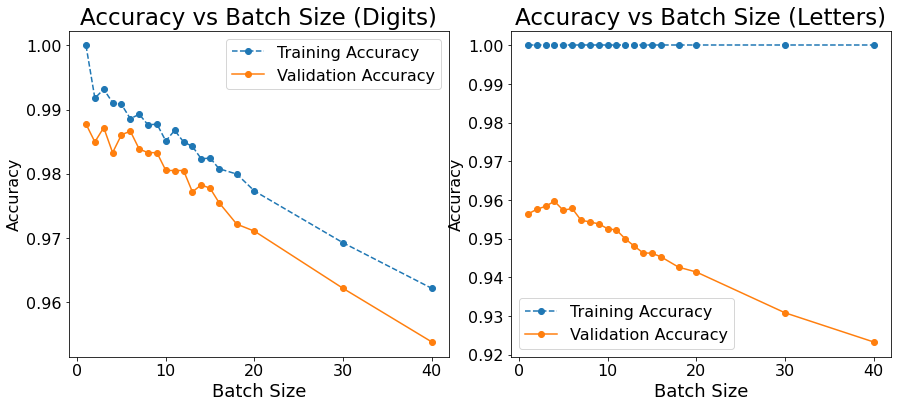

In [219]:
#set up
axes_digits, axes_letters = visualize('Batch Size', 'Accuracy')

#plot digit graph
axes_digits.plot(n_neighbours_knn_params_digits['n_neighbors'],training_accuracies_knn_digits, label= "Training Accuracy ", linestyle="--", marker="o")
axes_digits.plot(n_neighbours_knn_params_digits['n_neighbors'],validation_accuracies_knn_digits, label = "Validation Accuracy", marker="o")

#plot letter graph
axes_letters.plot(n_neighbours_knn_params_letters['n_neighbors'],training_accuracies_knn_letters, label= "Training Accuracy ", linestyle="--", marker="o")
axes_letters.plot(n_neighbours_knn_params_letters['n_neighbors'],validation_accuracies_knn_letters, label = "Validation Accuracy", marker="o")

#plot legends
axes_digits.legend(fontsize=16)
axes_letters.legend(fontsize=16)

##### Weight Tuning

In [224]:
weight_knn_params_digits = {
      'n_neighbors': best_knn_params_digits['n_neighbors'], 
      'weights': ['uniform','distance'],
}

weight_knn_params_letters = {
      'n_neighbors': best_knn_params_digits['n_neighbors'], 
      'weights': ['uniform','distance'],
}

In [225]:
_, _, training_accuracies_knn_digits, validation_accuracies_knn_digits = grid_search_knn(weight_knn_params_digits, digits_x_knn, digits_y_knn)

<ipython-input-210-a877ceb0a829>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(knn_params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'n_neighbors': 1
'weights': uniform

 Training Accuracy: 100.0%
 Validation Accuracy: 98.66450015475084%
--- HYPERPARAMETERS COMBINATION 1 ---

'n_neighbors': 1
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 98.49675023212627%


In [226]:
_, _, training_accuracies_knn_letters, validation_accuracies_knn_letters = grid_search_knn(weight_knn_params_letters, letters_x_knn, letters_y_knn)

<ipython-input-210-a877ceb0a829>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  params_list = np.array(list(knn_params.values()))


--- HYPERPARAMETERS COMBINATION 0 ---

'n_neighbors': 1
'weights': uniform

 Training Accuracy: 100.0%
 Validation Accuracy: 95.715%
--- HYPERPARAMETERS COMBINATION 1 ---

'n_neighbors': 1
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 95.72%


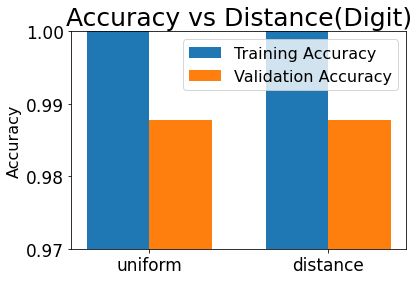

In [238]:
ind = np.arange(2) 
width = 0.35       
plt.bar(ind, training_accuracies_knn_digits, width, label='Training Accuracy')
plt.bar(ind + width, validation_accuracies_knn_digits, width,
    label='Validation Accuracy')

plt.ylabel('Accuracy' , fontsize=16)
plt.title('Accuracy vs Distance(Digit)', fontsize=25)

plt.ylim([0.97, 1])


plt.xticks(ind + width / 2, weight_knn_params_letters['weights'])
plt.tick_params(axis='x', labelsize=17)
plt.tick_params(axis='y', labelsize=17)
plt.legend(loc='best', fontsize=16)

plt.show()

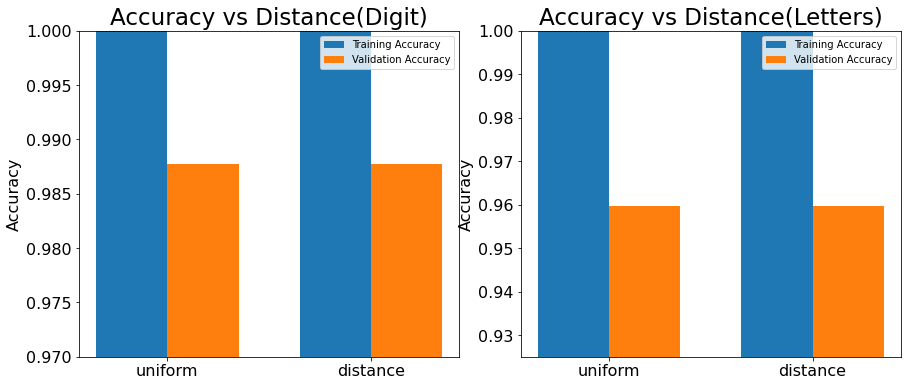

In [239]:
fig, ( accuracies_axes_digits, accuracies_axes_letters ) = plt.subplots(1,2)

chartBox = accuracies_axes_digits.get_position()
accuracies_axes_digits.set_position([chartBox.x0, chartBox.y0, 
                 chartBox.width*2.5, 
                 chartBox.height*1.5]) 
chartBox = accuracies_axes_letters.get_position() 
accuracies_axes_letters.set_position([0.6+chartBox.x0, chartBox.y0, 
                 chartBox.width*2.5, 
                 chartBox.height*1.5]) 

ind = np.arange(2) 
width = 0.35       

accuracies_axes_digits.bar(ind, training_accuracies_knn_digits, width, label='Training Accuracy')
accuracies_axes_digits.bar(ind + width, validation_accuracies_knn_digits, width,
    label='Validation Accuracy')

accuracies_axes_letters.bar(ind, training_accuracies_knn_letters, width, label='Training Accuracy')
accuracies_axes_letters.bar(ind + width, validation_accuracies_knn_letters, width,
    label='Validation Accuracy')

accuracies_axes_digits.set_xticks([width/2,1+width/2]) # values
accuracies_axes_digits.set_xticklabels(weight_knn_params_digits['weights']) # labels

accuracies_axes_letters.set_xticks([width/2,1+width/2]) # values
accuracies_axes_letters.set_xticklabels(weight_knn_params_digits['weights']) # labels

accuracies_axes_digits.set_ylabel('Accuracy')
accuracies_axes_digits.set_title('Accuracy vs Distance - Digit Dataset')
accuracies_axes_digits.title.set_size(23)
accuracies_axes_digits.xaxis.label.set_size(18)
accuracies_axes_digits.yaxis.label.set_size(16)
accuracies_axes_digits.tick_params(axis = 'both', which = 'major', labelsize = 16)

accuracies_axes_digits.set_ylim([0.97, 1])
accuracies_axes_letters.set_ylim([0.925, 1])



accuracies_axes_digits.legend(loc='best')
accuracies_axes_letters.legend(loc='best')

accuracies_axes_digits.set_ylabel('Accuracy')
accuracies_axes_digits.set_title('Accuracy vs Distance(Digit)')
accuracies_axes_digits.title.set_size(23)
accuracies_axes_digits.xaxis.label.set_size(18)
accuracies_axes_digits.yaxis.label.set_size(16)
accuracies_axes_digits.tick_params(axis = 'both', which = 'major', labelsize = 16)


accuracies_axes_letters.set_ylabel('Accuracy')
accuracies_axes_letters.set_title('Accuracy vs Distance(Letters)')
accuracies_axes_letters.title.set_size(23)
accuracies_axes_digits.xaxis.label.set_size(18)
accuracies_axes_letters.yaxis.label.set_size(16)
accuracies_axes_letters.tick_params(axis = 'both', which = 'major', labelsize = 16)

#### Best Softmax Regressor (GD) Model vs Best KNN Model

Getting Accuracies, Running time for best Softmax Regressor Model for Digits Dataset

In [240]:
_,_, training_accuracies_digits, validation_accuracies_digits, running_times_digits, _ = grid_search_softmax_regressor(best_optimiser_params_digits,digits_c,digits_x,digits_y, display = True)

--- HYPERPARAMETERS COMBINATION 0 ---

'inilearning_rate': 0.05
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 64
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 98.84540598507748%
 Validation Accuracy: 97.38409161250387%
 Run time: 2.446730613708496 seconds
 Cost: 0.12535398488928615



Getting Accuracies, Running time for best Softmax Regressor Model for Letters Dataset

In [241]:
_,_, training_accuracies_letters, validation_accuracies_letters, running_times_letters, _ = grid_search_softmax_regressor(best_optimiser_params_letters,letters_c,letters_x,letters_y, display = True)
start = time.time()

--- HYPERPARAMETERS COMBINATION 0 ---

'inilearning_rate': 0.07
'learning_rate_fn': <function learning_rate_const at 0x000002EF4B66AE50>
'momentumbeta': 0.85
'batch_size': 128
'max_iters': 10000
'epsilon': 1e-08
'T': 100
'record_history': False

 Training Accuracy: 71.77374999999999%
 Validation Accuracy: 72.03999999999999%
 Run time: 242.2426655292511 seconds
 Cost: 1.1118070948412173



Getting Accuracies, Running time for best KNN Model for Digits Dataset

In [242]:
start = time.time()
_, _, training_accuracies_knn_digits, validation_accuracies_knn_digits = grid_search_knn(best_knn_params_digits, digits_x_knn, digits_y_knn, display = True)
knn_digits_runtime = time.time() - start

--- HYPERPARAMETERS COMBINATION 0 ---

'n_neighbors': 1
'weights': uniform

 Training Accuracy: 100.0%
 Validation Accuracy: 98.55323429278862%


Getting Accuracies, Running time for best KNN Model for Letters Dataset

In [243]:
_, _, training_accuracies_knn_letters, validation_accuracies_knn_letters = grid_search_knn(best_knn_params_letters, letters_x_knn, letters_y_knn, display = True)
knn_letters_runtime = time.time() - start

--- HYPERPARAMETERS COMBINATION 0 ---

'n_neighbors': 4
'weights': distance

 Training Accuracy: 100.0%
 Validation Accuracy: 95.91000000000001%


##### Accuracies Comparison

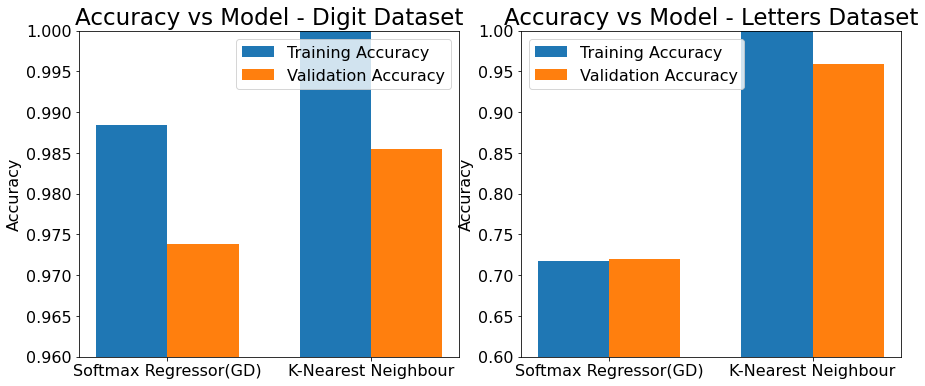

In [244]:
fig, ( accuracies_axes_digits, accuracies_axes_letters ) = plt.subplots(1,2)

chartBox = accuracies_axes_digits.get_position()
accuracies_axes_digits.set_position([chartBox.x0, chartBox.y0, 
                 chartBox.width*2.5, 
                 chartBox.height*1.5]) 
chartBox = accuracies_axes_letters.get_position() 
accuracies_axes_letters.set_position([0.6+chartBox.x0, chartBox.y0, 
                 chartBox.width*2.5, 
                 chartBox.height*1.5]) 

ind = np.arange(2) 
width = 0.35       

accuracies_axes_digits.bar(ind, [training_accuracies_digits[0],training_accuracies_knn_digits[0]], width, label='Training Accuracy')
accuracies_axes_digits.bar(ind + width, [validation_accuracies_digits[0],validation_accuracies_knn_digits[0]], width,
    label='Validation Accuracy')

accuracies_axes_letters.bar(ind, [training_accuracies_letters[0],training_accuracies_knn_letters[0]], width, label='Training Accuracy')
accuracies_axes_letters.bar(ind + width, [validation_accuracies_letters[0],validation_accuracies_knn_letters[0]], width,
    label='Validation Accuracy')

accuracies_axes_digits.set_xticks([width/2,1+width/2]) # values
accuracies_axes_digits.set_xticklabels(['Softmax Regressor(GD)','K-Nearest Neighbour']) # labels

accuracies_axes_letters.set_xticks([width/2,1+width/2]) # values
accuracies_axes_letters.set_xticklabels(['Softmax Regressor(GD)','K-Nearest Neighbour']) # labels

accuracies_axes_digits.set_ylabel('Accuracy')
accuracies_axes_digits.set_title('Accuracy vs Distance - Digit Dataset')
accuracies_axes_digits.title.set_size(23)
accuracies_axes_digits.yaxis.label.set_size(16)
accuracies_axes_digits.xaxis.label.set_size(18)
accuracies_axes_digits.tick_params(axis = 'both', which = 'major', labelsize = 16)


accuracies_axes_digits.set_ylim([0.96, 1])
accuracies_axes_letters.set_ylim([0.6, 1])

accuracies_axes_digits.legend(loc='best', fontsize=16)
accuracies_axes_letters.legend(loc='best', fontsize=16)


accuracies_axes_digits.set_ylabel('Accuracy')
accuracies_axes_digits.set_title('Accuracy vs Model - Digit Dataset')
accuracies_axes_digits.title.set_size(23)
accuracies_axes_digits.yaxis.label.set_size(16)
accuracies_axes_digits.xaxis.label.set_size(18)
accuracies_axes_digits.tick_params(axis = 'both', which = 'major', labelsize = 16)

accuracies_axes_letters.set_ylabel('Accuracy')
accuracies_axes_letters.set_title('Accuracy vs Model - Letters Dataset')
accuracies_axes_letters.title.set_size(23)
accuracies_axes_letters.yaxis.label.set_size(16)
accuracies_axes_letters.xaxis.label.set_size(18)
accuracies_axes_letters.tick_params(axis = 'both', which = 'major', labelsize = 16)

##### Running time Comparison

(12.338974714279175, 244.2426655292511)

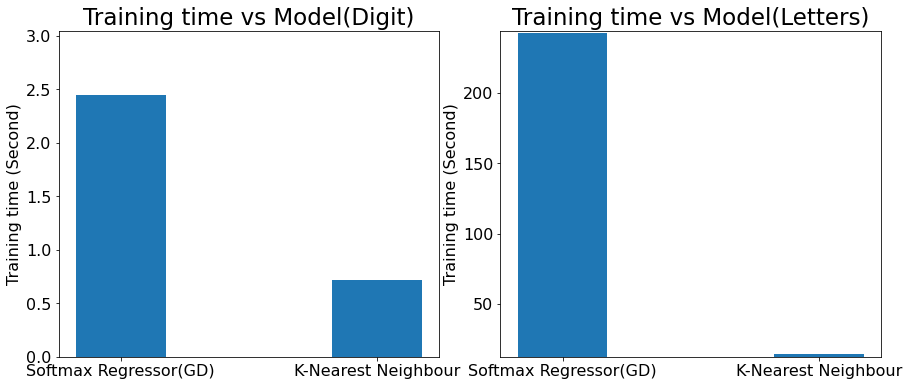

In [245]:
fig, ( runningtime_axes_digits, runningtime_axes_letters ) = plt.subplots(1,2)

chartBox = runningtime_axes_digits.get_position()
runningtime_axes_digits.set_position([chartBox.x0, chartBox.y0, 
                 chartBox.width*2.5, 
                 chartBox.height*1.5]) 
chartBox = runningtime_axes_letters.get_position() 
runningtime_axes_letters.set_position([0.6+chartBox.x0, chartBox.y0, 
                 chartBox.width*2.5, 
                 chartBox.height*1.5]) 

ind = np.arange(2) 
width = 0.35

runningtime_axes_digits.bar(ind, [running_times_digits[0],knn_digits_runtime], width)

runningtime_axes_letters.bar(ind, [running_times_letters[0],knn_letters_runtime], width)


runningtime_axes_digits.set_xticks([0,1]) # values
runningtime_axes_digits.set_xticklabels(['Softmax Regressor(GD)','K-Nearest Neighbour']) # labels

runningtime_axes_letters.set_xticks([0,1]) # values
runningtime_axes_letters.set_xticklabels(['Softmax Regressor(GD)','K-Nearest Neighbour']) # labels

runningtime_axes_digits.set_ylabel('Training time (Second)')
runningtime_axes_digits.set_title('Training time vs Model(Digit)')

runningtime_axes_letters.set_ylabel('Training time (Second)')
runningtime_axes_letters.set_title('Training time vs Model(Letters)')

runningtime_axes_digits.title.set_size(23)
runningtime_axes_digits.xaxis.label.set_size(18)
runningtime_axes_digits.yaxis.label.set_size(16)
runningtime_axes_digits.tick_params(axis = 'both', which = 'major', labelsize = 16)

runningtime_axes_letters.title.set_size(23)
runningtime_axes_letters.xaxis.label.set_size(18)
runningtime_axes_letters.yaxis.label.set_size(16)
runningtime_axes_letters.tick_params(axis = 'both', which = 'major', labelsize = 16)

runningtime_axes_digits.set_ylim([0, max(running_times_digits[0],knn_digits_runtime)+0.6])
runningtime_axes_letters.set_ylim([min(running_times_letters[0],knn_letters_runtime)-2, max(running_times_letters[0],knn_letters_runtime)+2])

### Naive Bayes

We will finally see if Naive Bayes works good in these two datasets. First let's make a kfold_cross_validate_NB, because it trains differently from other two models

In [3]:
def kfold_cross_validate_NB( model, x, y, kfold_num=5 ):   #some change
    kfold = KFold(k=kfold_num)
    validation_accuracy = 0
    training_accuracy = 0
    model_ = copy.copy(model)
    for (x_train, y_train), (x_test, y_test) in kfold.split(x,y):
        themodel = copy.copy(model_) 
        themodel.fit(x_train, y_train)
        training_accuracy += (y_train == themodel.predict(x_train)).sum()/y_train.shape[0]
        validation_accuracy += (y_test == themodel.predict(x_test)).sum()/y_test.shape[0]
    return training_accuracy/kfold_num , validation_accuracy/kfold_num

Note that there is no hyperparameter for Naive Bayes, so we get the accuracy of Naive Bayes directly.

In [4]:
gnb = GaussianNB()
digits_x, digits_y = load_digits(return_X_y=True)
train_accuracy, valid_accuracy = kfold_cross_validate_NB( gnb, digits_x, digits_y, kfold_num=5 )
print("for digits dataset:\ntrain_accuracy: " + str(train_accuracy) + "\nvalidation accuracy: " + str(valid_accuracy) + "\n\n")


gnb = GaussianNB()
letters_x, letters_y = fetch_openml(data_id=6, return_X_y=True)
train_accuracy, valid_accuracy = kfold_cross_validate_NB( gnb, letters_x, letters_y, kfold_num=5 )
print("for letters dataset:\ntrain_accuracy: " + str(train_accuracy) + "\nvalidation accuracy: " + str(valid_accuracy))

for digits dataset:
train_accuracy: 0.8553144928924906
validation accuracy: 0.8430841844630145


for letters dataset:
train_accuracy: 0.6471375000000001
validation accuracy: 0.6412


They produce fine results, but worse than both models above. The reason is that the features are correlated: the pixels are correlated, because for many pixels, it can be inferred, for example, if 8 of the neighbors of a pixel all have high value, then this pixel will probably have a high value, similar with its neighbors. Similarly, the statistical values are somehow related as well, though maybe not very correlated. As a result, that features are independent is against the assumption of the two datasets, so Naive Bayes does not make good predictions on these two datasets.